In [ ]:
%load_ext autoreload
%autoreload 2

# GANs

In this seminar, you will learn how to

* Solve generative modelling problems with Generative Adversarial Networks (GANs)

* Implement
    * Vanilla GAN loss
    * Non-saturating GAN loss (with $R_1$ regularization)
<!--     * Wasserstein GAN loss with Gradient pentaly  -->
    
* Apply GANs for modelling
    * toy 2D distribution
    * not so toy $3\times 16\times 16$ image data

**Related works** and **repositories** to consider:
* The seminal *Generative Adversarial Networks* [paper](https://arxiv.org/abs/1406.2661) by *Ian Goodfellow et. al.*;
* NIPS 2016 [tutorial](https://arxiv.org/abs/1701.00160) on Generative Adversarial Networks by *Ian Goodfellow* (saturating and non-saturating GANs covered);
<!-- * *Wasserstein GAN* [paper](https://arxiv.org/abs/1701.07875) by *Martin Arjovsky et. al.*, *Improved Training of Wasserstein GANs* [paper](https://arxiv.org/abs/1704.00028) by *Ishaan Gulrajani et. al.* (WGAN with Gradient Penalty); -->
* Deep Generative Models course at MIPT, [github](https://github.com/r-isachenko/2022-2023-DGM-MIPT-course). **This seminar is partially based on the materials of this course**.

### **Auxiliary code**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import numpy as np
from matplotlib import pyplot as plt
from typing import Optional, Union, Sequence, Dict, Tuple, List
from tqdm import tqdm

#############
# cuda setup

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

#############
# visualizations

def visualize_2d_samples(
    data: np.ndarray,
    title: str,
    colors: Optional[Union[Sequence[str], str]] = None,
    xlabel: Optional[str] = None,
    ylabel: Optional[str] = None,
    alpha: Optional[float] = None,
    s: Optional[float] = 1
) -> None:
    plt.figure(figsize=(5, 5))
    plt.scatter(data[:, 0], data[:, 1], s=s, c=colors, alpha=alpha)
    plt.title(title, fontsize=16)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    if xlabel is not None:
        plt.xlabel(xlabel, fontsize=14)
    if ylabel is not None:
        plt.ylabel(ylabel, fontsize=14)
    plt.show()

###########
# GANDiagnosticCompanion

def computePotGrad(input, output, create_graph=True, retain_graph=True):
    '''
    :Parameters:
    input : tensor (bs, *shape)
    output: tensor (bs, 1) , NN(input)
    :Returns:
    gradient of output w.r.t. input (in batch manner), shape (bs, *shape)
    '''
    grad = torch.autograd.grad(
        outputs=output,
        inputs=input,
        grad_outputs=torch.ones_like(output),
        create_graph=create_graph,
        retain_graph=retain_graph,
    ) # (bs, *shape)
    return grad[0]

def make_inference(generator, critic, n_samples=5000, compute_grad_norms=True):
    generator.eval()
    critic.eval()
    xs = np.linspace(-3.0, 3.0, 1000 + 1)
    xg, yg = np.meshgrid(xs, xs)
    grid = np.concatenate((xg.reshape(-1, 1), yg.reshape(-1, 1)), axis=-1)

    tsr_grid = torch.FloatTensor(grid).to(next(iter(generator.parameters())))
    with torch.no_grad():
        samples = generator.sample(n_samples).cpu().detach().numpy()
        critic_output = critic(tsr_grid).cpu().detach().numpy()

    if compute_grad_norms:
        tsr_grid.requires_grad_() # (grid_size, 2)
        _critic_output = critic(tsr_grid) # (grid_size, 1)
        assert len(critic_output.shape) == 2
        grads = computePotGrad(
            tsr_grid, _critic_output,
            create_graph=False, retain_graph=False) # (grid_size, 2)
        critic_grad_norms = torch.norm(grads, dim=-1).detach().cpu().numpy().reshape((1000 + 1, 1000 + 1))

    critic_output = np.prod(critic_output, axis=-1).reshape((1000 + 1, 1000 + 1))
    if compute_grad_norms:
        return samples, grid, critic_output, critic_grad_norms
    return samples, grid, critic_output

def visualize_GAN_output(
    generated_samples, real_samples, grid,
    critic_output, critic_grad_norms, npts=100 + 1):

    fig, ax = plt.subplots(1, 2, figsize=(14, 6))

    npts = critic_output.shape[0]
    cnt = ax[0].contourf(
        grid[:, 0].reshape((npts, npts)), grid[:, 1].reshape((npts, npts)), critic_output,
        levels=25, cmap="cividis"
    )
    ax[0].scatter(real_samples[:, 0], real_samples[:, 1], marker="x", color="blue", s=0.5, label='GT spls')
    ax[0].scatter(generated_samples[:, 0], generated_samples[:, 1], marker=".", color="red", s=0.5, label='gen spls')
    ax[0].set_title('Critic/discriminator outputs', fontsize=16)
    ax[0].legend(fontsize=12)
    fig.colorbar(cnt, ax=ax[0])
    cnt = ax[1].contourf(
        grid[:, 0].reshape((npts, npts)), grid[:, 1].reshape((npts, npts)), critic_grad_norms,
        levels=25, cmap="cividis"
    )
    ax[1].set_title('Norms of critic/discriminator gradients', fontsize=16)
    fig.colorbar(cnt, ax=ax[1])
    plt.show()


class GANDiagnosticCompanion:

    def __init__(
        self,
        G : nn.Module,
        D : nn.Module,
        reference_data : np.ndarray
    ) -> None:
        self.generator_losses = []
        self.discriminator_losses = []
        self.G = G
        self.D = D
        self.reference_data = reference_data

    def upd_g_loss(self, g_loss : float):
        self.generator_losses.append(g_loss)

    def upd_d_loss(self, d_loss : float):
        self.discriminator_losses.append(d_loss)

    def visualize_losses(self):
        fig, axs = plt.subplots(1, 2, figsize=(14, 5))
        names = ['gen loss', 'discr loss']
        losses = [self.generator_losses, self.discriminator_losses]
        for name, ax, loss in zip(names, axs, losses):
            ax.plot(range(len(loss)), loss)
            ax.set_title(name, fontsize=16)
            ax.set_xlabel("iteration", fontsize=14); ax.set_ylabel("loss", fontsize=14)
            plt.xticks(fontsize=12); plt.yticks(fontsize=12)
            ax.grid(which='major')
        plt.show()

    def visualize(self):
        self.visualize_losses()
        # raise NotImplementedError()

class GANDiagnosticCompanion2D(GANDiagnosticCompanion):

    def visualize(self):
        self.visualize_losses()
        samples, grid, discr_output, discr_grad_norms = make_inference(self.G, self.D)
        visualize_GAN_output(samples, self.reference_data, grid, discr_output, discr_grad_norms)

def plot_images(batch, title=None):
    fig, axes = plt.subplots(1, 10, figsize=(10, 1), dpi=100)
    for i in range(10):
        axes[i].imshow(batch[i].mul(0.5).add(0.5).clip(0,1).permute(1,2,0))
        axes[i].set_xticks([]); axes[i].set_yticks([])
    if title is not None:
        fig.suptitle(title, fontsize=16)
    fig.tight_layout(pad=0.1)
    plt.show()

class GANDiagnosticCompanionImages(GANDiagnosticCompanion):

    def visualize(self):
        self.visualize_losses()
        plot_images(torch.tensor(self.reference_data[:10]), 'Ground Truth samples')
        plot_images(self.G.sample(10).detach().cpu(), 'Generated samples')



## 0. Generative modelling problem

We have samples $\{x_1, x_2, \dots, x_n\} = X \sim \mathbb{P}(x)$. The distribution $\mathbb{P} \in \mathcal{P}(\mathbb{R}^{D_x})$ is unknown.

We look for **parametric** approximation $p(x|\theta), \theta \in \Theta$ of $\mathbb{P}(x)$, and pick up $\theta^*$ such that  $\mathbb{P}(x) \approx p(x|\theta^*)$.

We want to estimate $\hat{\theta^*} = \hat{\theta^*}(X)$ in order to

* sample from $p(x|\hat{\theta^*})$ <span style="color:green"> __(Primary goal)__ </span>

* ~~estimate the corresponding pdf.~~ <span style="color:orange"> (Less relevant) </span>

### 0.1 Latent Variable Model

<center>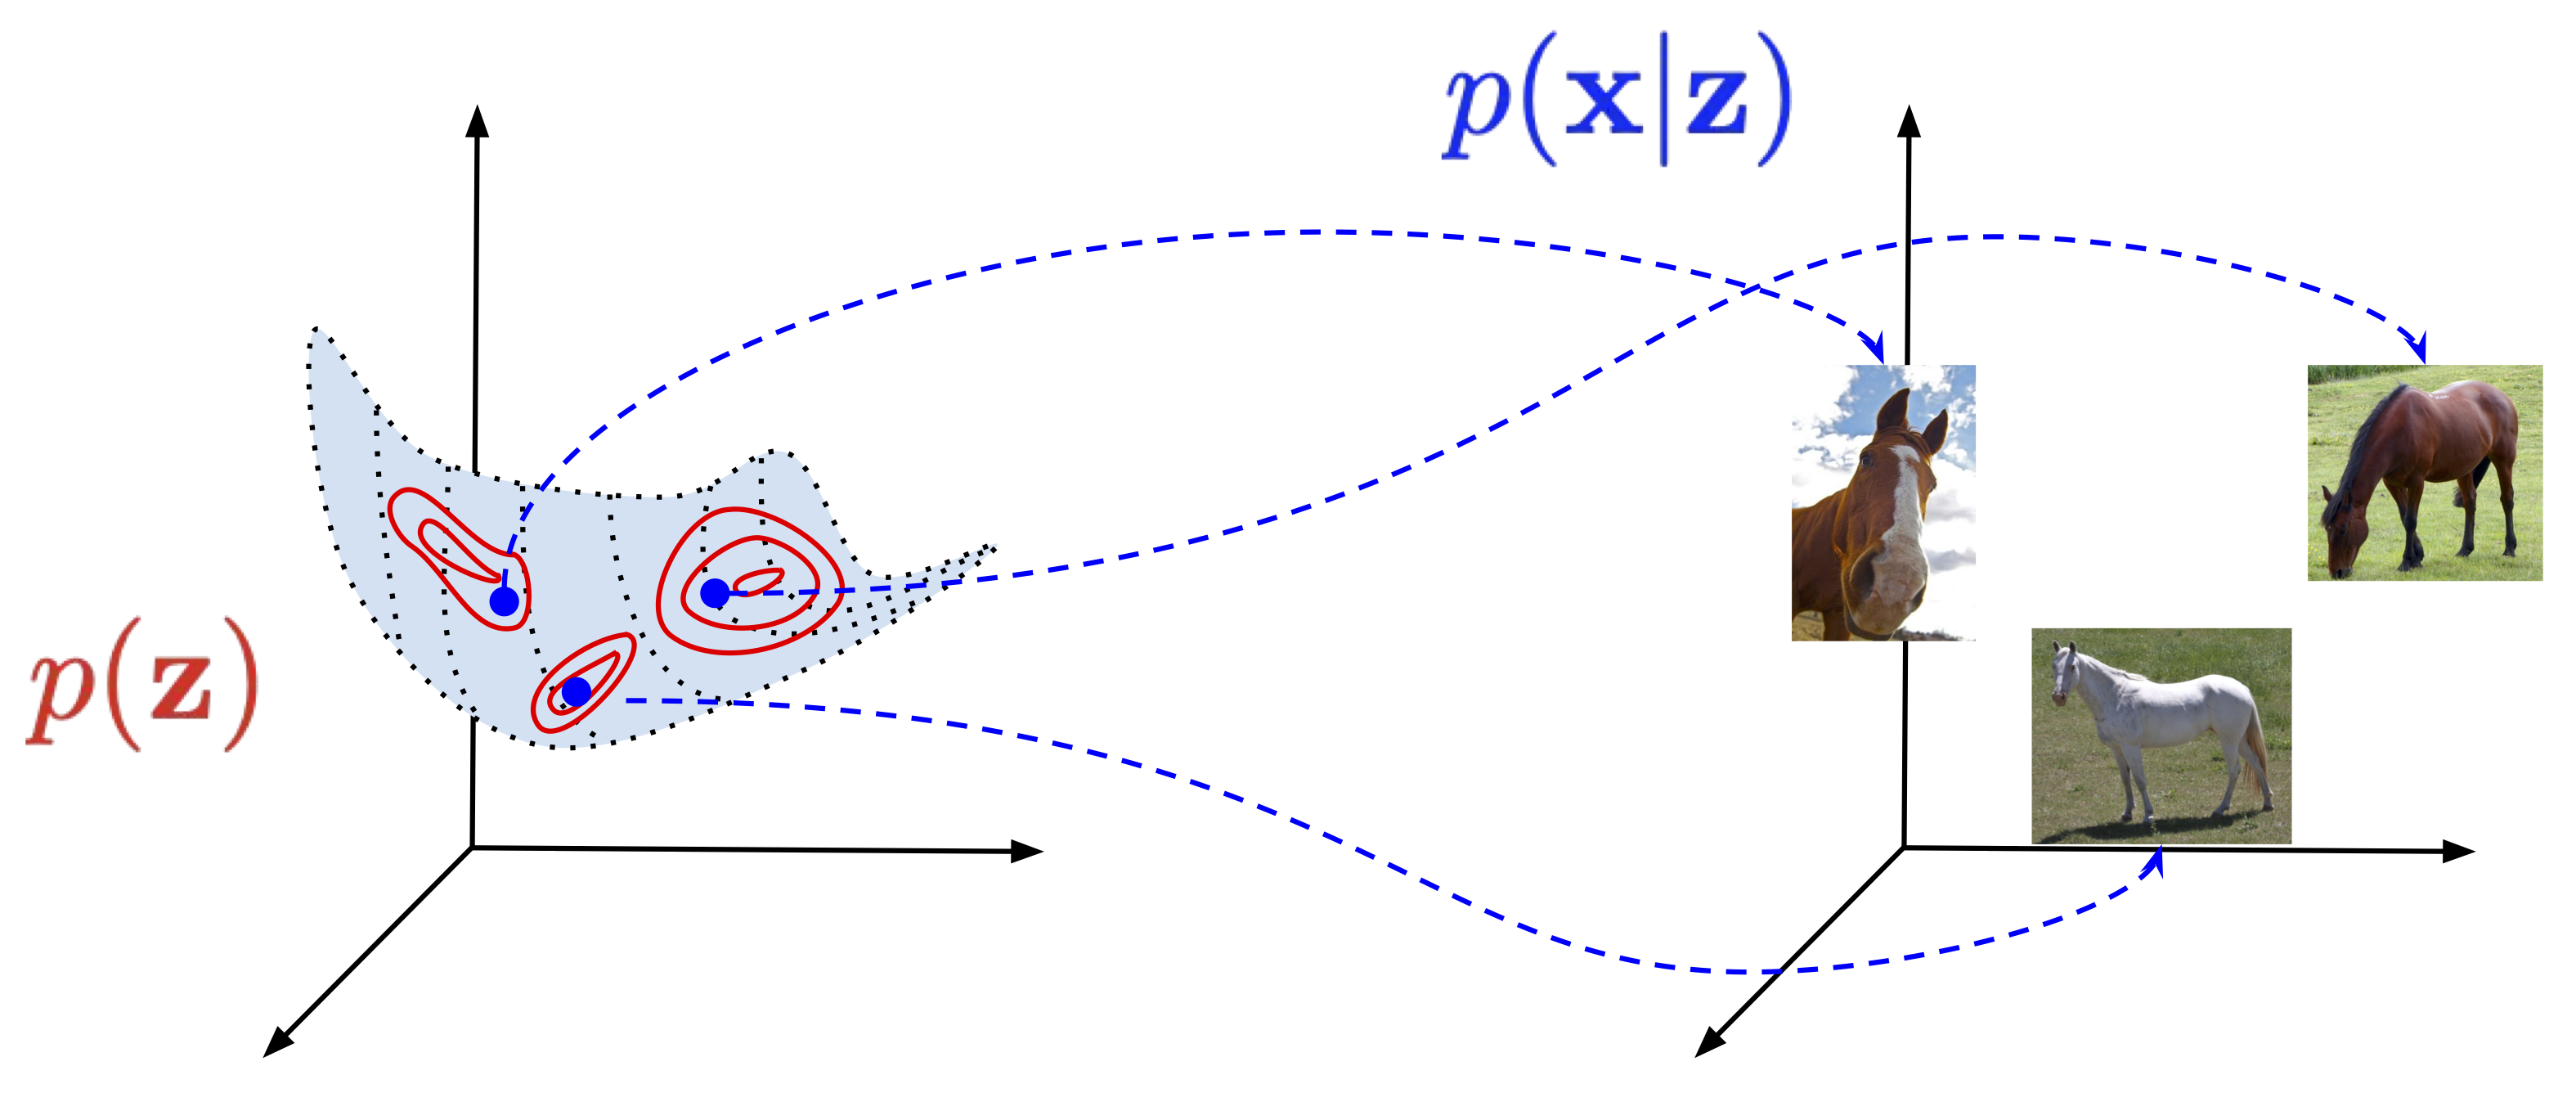</center>

**Likelihood**

$p(x |\theta) = \int\limits_{\mathbb{R}^{D_z}} p(x | z, \theta) p_z(z| \theta) dz$

* Typically, latent distribution $p_z(z| \theta)$ is simple and does not depend on $\theta$: $p_z(z| \theta) = p_z(z)$

**Sampling procedure**

* Sample $z^* \sim p_z(z | \theta)$

* Sample $x \sim p(x | z^*, \theta)$

## 1. Toy $2D$ problem setup

Setting up reference distribution $\mathbb{P}$

In [ ]:
def generate_2d_data(size : int, var : float = 0.02) -> np.ndarray:
    scale = 2
    centers = [
        (1, 0),
        (-1, 0),
        (0, 1),
        (0, -1),
        (1. / np.sqrt(2), 1. / np.sqrt(2)),
        (1. / np.sqrt(2), -1. / np.sqrt(2)),
        (-1. / np.sqrt(2), 1. / np.sqrt(2)),
        (-1. / np.sqrt(2), -1. / np.sqrt(2))
    ]

    centers = [(scale * x, scale * y) for x, y in centers]
    dataset = []

    for i in range(size):
        point = np.random.randn(2) * var
        center = centers[np.random.choice(np.arange(len(centers)))]
        point[0] += center[0]
        point[1] += center[1]
        dataset.append(point)

    dataset = np.array(dataset, dtype='float32')
    dataset /= 1.414  # stdev

    return dataset

Generate and visualize training samples $X \sim \mathbb{P}$

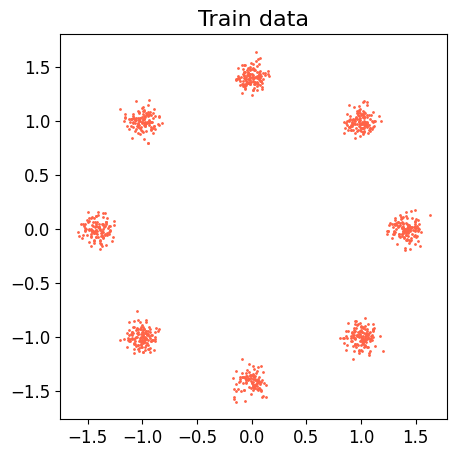

In [ ]:
COUNT = 20000

train_data = generate_2d_data(COUNT, var=0.1)
visualize_2d_samples(train_data[:1000], "Train data", colors='tomato')

## 2. GAN losses

In this part of the seminar you will get into details and implement `Vanillan GAN` and `Non-saturating Vanilla GAN` models. Then you will apply these models on the toy $2D$ problem from above.

### 2.0. GAN preliminaries

Generative Adversarial Networks parameterizes the distributions $p(x \vert \theta)$ by means of

* <ins>Simple</ins>, <ins>pre-defined</ins>, typically <ins> low-dimensional </ins> latent distribution $p_z(z)$, e.g., Gaussian or Uniform

* A parametric generator model $G_{\theta} : \mathbb{R}^{D_z} \rightarrow \mathbb{R}^{D_x}$ which maps latent space to data space

__Formal probability model.__ Generator $G_{\theta}$ coupled with latent distribution $p_z(z)$ forms the parametric distribution $p(x \vert \theta)$ which is the distribution of points $x = G_{\theta}(z)$, where $z \sim p_z(z)$. I.e.,

$$
p(x \vert \theta) = p_z\big(G_{\theta}^{-1}(x)\big).
$$

🔎 __Remark.__ In the literature, $p(x \vert \theta)$ typically called as __pushforward__ of $p_z(z)$ under $G_{\theta}$:

$$
p(\cdot \vert \theta) = G_{\theta}\sharp p_z
$$

**Sampling from $p(x \vert \theta)$ procedure**

* Sample $z^* \sim p_z(z)$

* Obtain $x = G_{\theta}(z^*)$

#### Training GANs

We need to adjust the optimal NN parameters $\hat{\theta^*}$ based on samples $X \sim \mathbb{P}$ such that $\mathbb{P}(x) \approx p(x|\hat{\theta^*})$

This can be done by choosing a __discrepancy__

$$\mathfrak{D} : \mathcal{P}(\mathbb{R}^{D_x}) \times \mathcal{P}(\mathbb{R}^{D_x}) \rightarrow \mathbb{R}$$

between probability distributions and __minimizing__ $\mathfrak{D}(p(x|\theta), \mathbb{P})$ <ins>based on samples</ins> $X$.

❔ What discrepancies $\mathfrak{D}$ do you know? Which of them are used in generative modelling?

<p style="padding: 10px; border: 2px solid red; text-align: center;"> In GAN setup, the discrepancy is typically follow the <b>variational manner</b>, i.e., it is defined as an <u>auxiliary optimization problem</u> w.r.t. a discriminator (or critic) $D: \mathbb{R}^{D_x} \rightarrow \mathbb{R}$:
$$\mathfrak{D}(p(x|\theta), \mathbb{P}) = \sup_{D} V(G_{\theta}, D)$$

</p>

* Discriminator $D$ is parameterized as a NN: $D = D_{\phi}, \phi \in \Phi$

* Typically, the <u>"physical" role</u> of discriminator $D$ is to __distinguis__ real samples $X$ from generated samples $X_{\text{gen}} \sim G_{\theta}\sharp p_z$

* The resulting Generative Modelling problem is solved by $\min - \max$ <u>adversarial</u> optimization problem:

$$\min_{G_{\theta}} \max_{D_{\phi}} V(G_{\theta}, D_{\phi}) = \min_{\theta \in \Theta} \max_{\phi \in \Phi} V(G_{\theta}, D_{\phi}) \rightarrow \hat{\theta^*}, \hat{\phi^*}$$

#### Parameterizing with Neural Networks

Now let's gradually move to practice. Define a class for MultiLayerPerceptron. It will be used for modelling generators $G_{\theta}$ and discriminators $D_{\phi}$ of our GAN models on the  toy 2D problem.

In [ ]:
class FullyConnectedMLP(nn.Module):

    def __init__(
        self,
        input_dim : int,
        hiddens : List[int], # hidden layer's dimensions
        output_dim : int
    ) -> None:
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hiddens = hiddens

        model = []
        prev_h = input_dim
        for h in hiddens:
            model.append(nn.Linear(prev_h, h))
            model.append(nn.ReLU())
            prev_h = h
        model.append(nn.Linear(hiddens[-1], output_dim))
        self.net = nn.Sequential(*model)

    def forward(self, x : torch.Tensor) -> torch.Tensor:
        batch_size = x.shape[0]
        x = x.view(batch_size, -1)
        return self.net(x).view(batch_size, self.output_dim)

### 2.1 Vanilla GAN

**Vanilla GAN objective**

\begin{align}
\min_G \max_D V(G, D) &= \min_G \max_D \big[\mathbb{E}_{x \sim \mathbb{P}} \log D(x) + \mathbb{E}_{x_{\text{gen}} \sim p(x \vert \theta)} \log(1 - D(x_{\text{gen}}))\big] \\
&= \min_G \max_D \big[\mathbb{E}_{x \sim \mathbb{P}} \log D(x) + \mathbb{E}_{z \sim p_z(z)} \log(1 - D(G(z)))\big]
\end{align}

* __Generator:__ generative model $x = G(z)$, which try to generate samples <u>indistiguishable</u> from real samples $X \sim \mathbb{P}$

* __Discriminator:__ a classifier $D(x) \in [0, 1]$, which <u>distiguishes</u> reals samples from generated samples

❔ Which discrepancy $\mathfrak{D}$ is optimized in the internal maximization problem? [💡 <i>Hint:</i> Recall the lecture]

-------------

**Sample estimate** of Vanilla GAN objective:

* The objective $V$ is stochastically estimated by deriving a random batch $X_B \subset X$ and random batch sample $Z_B \sim p_z$:

$$
\hat{V}(G, D) = \bigg[\frac{1}{\vert X_B \vert} \sum_{x \in X_B} \log D(x) + \frac{1}{\vert Z_B \vert} \sum_{z \in Z_B} \log(1 - D(G(z)))\bigg].
$$

* The problem is solved by alternating stochastic gradient descent-ascent steps w.r.t. parameters $\theta$ and $\phi$.

#### Implementing Vanilla GAN for toy 2D problem

* As latent distribution $p(z)$ we will use $D_z$-dimensional Standard gaussian distribution. Choose $D_z$ on your own. The author utilizes $D_z = 16$.

❔ What are the input and output dimensions of generator $G_\theta$ and discriminator $D_\theta$ models?

-------------


<!-- Define the generator $G :\mathbb{R}^{2}\rightarrow \mathbb{R}^{2}$ and discriminator $D :\mathbb{R}^{2}\rightarrow \mathbb{R}$. It sufficies to use medium-size multi-layer perceptrons for $G, D$ with ReLU activations. -->

Define the `Vanilla GAN` <b>generator</b> $G :\mathbb{R}^{D_z}\rightarrow \mathbb{R}^{2}$.
* It sufficies to use medium-size multi-layer perceptron with ReLU activations.
* Take the advantage of `FullyConnectedMLP` class.
* Implement `sample` method.

In [ ]:
class VanillaGenerator(FullyConnectedMLP):

    def sample(self, n : int) -> torch.Tensor:
        z = torch.randn(size=(n, self.input_dim)).to(
            next(iter(self.parameters())))
        return self.forward(z)

GEN_HIDDENS = [128, 128, 128]

G = VanillaGenerator(2, GEN_HIDDENS, 2).to(DEVICE)

Define the `Vanilla GAN` <b>discriminator</b> $D :\mathbb{R}^{2}\rightarrow \mathbb{R}$.
* It sufficies to use medium-size multi-layer perceptron with ReLU activations.
* Take the advantage of `FullyConnectedMLP` class.
* Note that the output of $D$ <u>should be restricted</u> to $[0, 1]$ segment.

In [ ]:
class VanillaDiscriminator(FullyConnectedMLP):

    def forward(self, z : torch.Tensor) -> torch.Tensor:
        x = super().forward(z)
        return torch.sigmoid(x)

DISCR_HIDDENS = [128, 128, 128]

D = VanillaDiscriminator(2, DISCR_HIDDENS, 1).to(DEVICE)

#### Implementing Vanilla GAN Loss

* Note, you will use the same function on images data problem

* It is recommended to use `torch.nn.functional.binary_cross_entropy` ([link to docs](https://pytorch.org/docs/stable/generated/torch.nn.functional.binary_cross_entropy.html#torch-nn-functional-binary-cross-entropy)) (to eliminate possible inifinity or large values)

Implement `Vanilla GAN` <b>generator</b> training step.

* The function below should compute the stocastic estimate $\hat{V}$ of Vanilla GAN loss and perform a single gradient descent step w.r.t the parameter $\theta$ of the generator.

In [ ]:
def vanilla_gen_step(
    X : torch.Tensor, # random batch from the dataset
    G : nn.Module, # generator model
    D : nn.Module, # discriminator model
    G_optim : torch.optim.Optimizer, # optimizer for generator (Adam/RMSprop/SGD etc.)
) -> torch.Tensor: # returns the value of loss to track the training statistics
    G.train()
    D.eval()
    batch_size = X.size(0)
    X_gen = G.sample(batch_size)
    scores_gen = D(X_gen)
    loss = - F.binary_cross_entropy(scores_gen, torch.zeros_like(scores_gen))
    G_optim.zero_grad()
    loss.backward()
    G_optim.step()
    return loss.item()

Implement `Vanilla GAN` <b>discriminator</b> training step.

* The function below should compute the stocastic estimate $\hat{V}$ of Vanilla GAN loss and perform a single gradient ascent step w.r.t the parameter $\phi$ of the discriminator.

In [ ]:
def vanilla_discr_step(
    X : torch.Tensor, # random batch from the dataset
    G : nn.Module, # generator model
    D : nn.Module, # discriminator model
    D_optim : torch.optim.Optimizer, # optimizer for the discriminator (Adam/RMSprop/SGD etc.)
) -> torch.Tensor: # returns the value of loss to track the training statistics
    G.eval()
    D.train()
    batch_size = X.size(0)
    with torch.no_grad():
        X_gen = G.sample(batch_size)
    scores_gen = D(X_gen)
    scores_real = D(X)
    loss_gen = F.binary_cross_entropy(scores_gen, torch.zeros_like(scores_gen))
    loss_real = F.binary_cross_entropy(scores_real, torch.ones_like(scores_real))
    loss = loss_gen + loss_real

    D_optim.zero_grad()
    loss.backward()
    D_optim.step()
    return loss.item()


Implement `Vanilla GAN` __training loop__

* It is not possible (and, actually, is a __bad__ strategy from the optimization perspectives) to solve the internal maximization problem $\max_{\phi} V(G_\theta, D_\phi)$ for each particular generator $G_\theta$.

* Instead, we will perform a fixed number of `discriminator_steps` gradient ascent updates of the discriminator parameter $\phi$ per each gradient descent update of the generator parameter $\theta$

* Afterwards we will see that setting `discriminator_steps` to large numbers will <u>spoil</u> the optimization and convergence.

In [ ]:
def train_vanilla(
    train_loader : DataLoader, # dataloader of training dataset
    G : nn.Module, # generator model
    D : nn.Module, # discriminator model
    G_optim : torch.optim.Optimizer, # optimizer for the generator
    D_optim : torch.optim.Optimizer, # optimizer for the discriminator
    discriminator_steps : int, # number of discriminators steps per each generator step
    n_epochs : int, # number of training epochs
    diagnostic : GANDiagnosticCompanion, # tracking statistics & visualization
    visualize_steps : int = 10, # for visualization purposes
) -> None:

    G.train()
    D.train()
    step_i = 0
    for epoch_i in tqdm(range(n_epochs)):
        for batch_i, X in enumerate(train_loader):
            X = X.to(DEVICE)

            # DISCRIMINATOR UPDATE
            d_loss = vanilla_discr_step(X, G, D, D_optim)
            diagnostic.upd_d_loss(d_loss)

            # GENERATOR UPDATE
            if step_i % discriminator_steps == 0:
                g_loss = vanilla_gen_step(X, G, D, G_optim)
                diagnostic.upd_g_loss(g_loss)
            step_i += 1

        if visualize_steps and epoch_i % visualize_steps == 0:
            print('Epoch {}'.format(epoch_i))
            diagnostic.visualize()

#### Vanilla GAN training

🔎 **Remark.** It is recommended to use `RMSprop` optimizer when training a GAN model. Empirically, it was observed that this optimizer works more stable compared to `Adam`.

  0%|                                                                                                                                              | 0/1000 [00:00<?, ?it/s]

Epoch 0


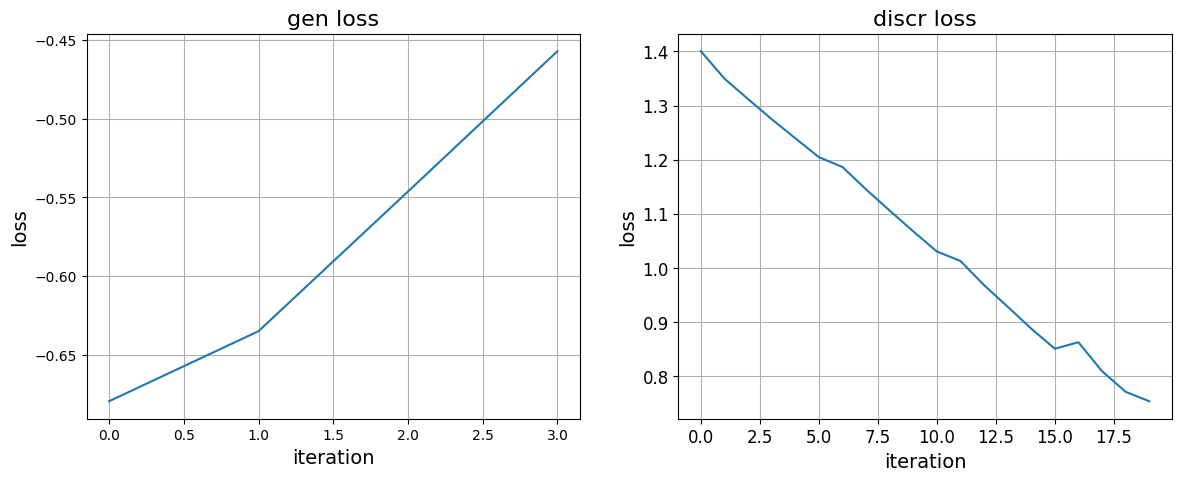

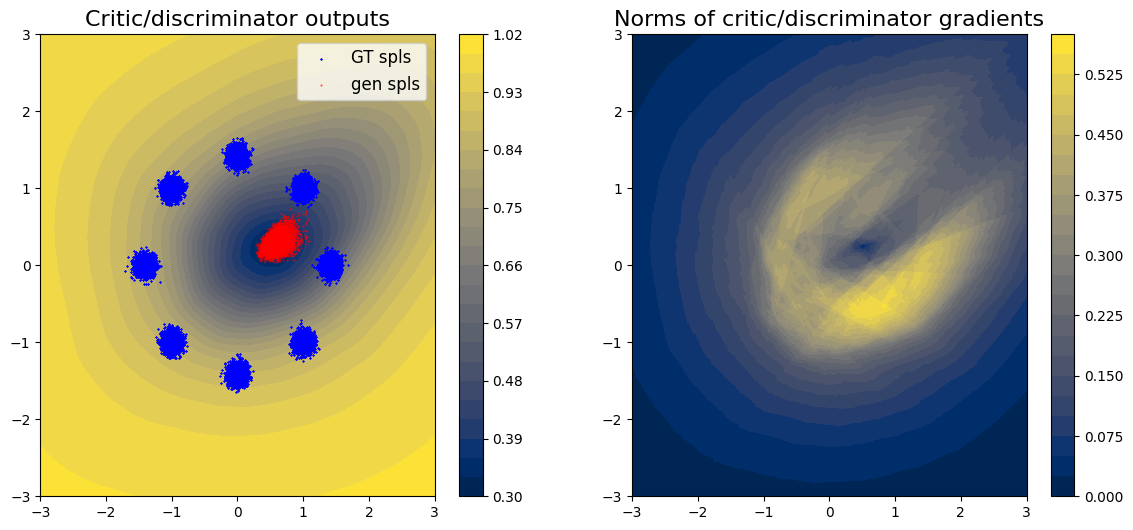

 10%|█████████████▏                                                                                                                      | 100/1000 [00:22<02:53,  5.17it/s]

Epoch 100


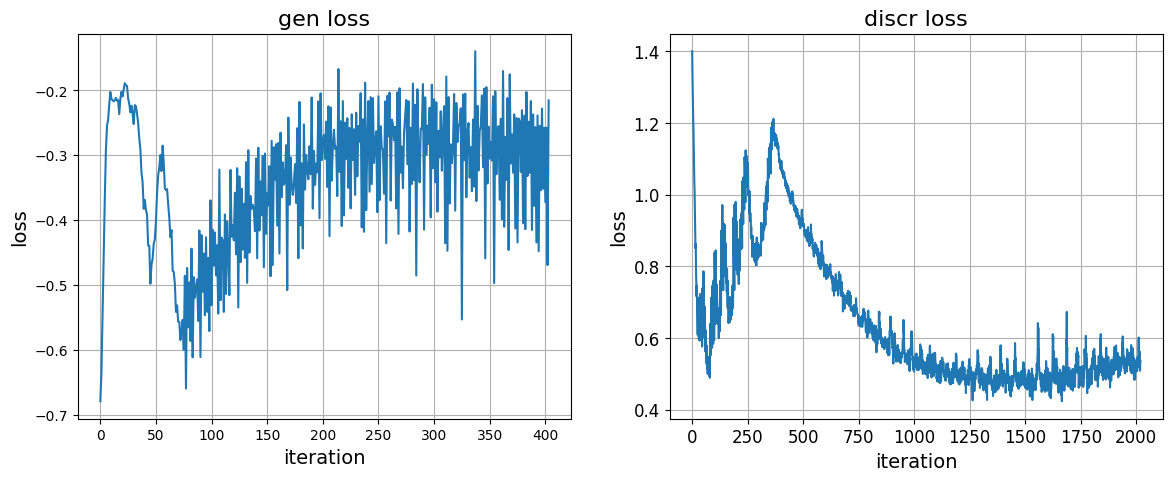

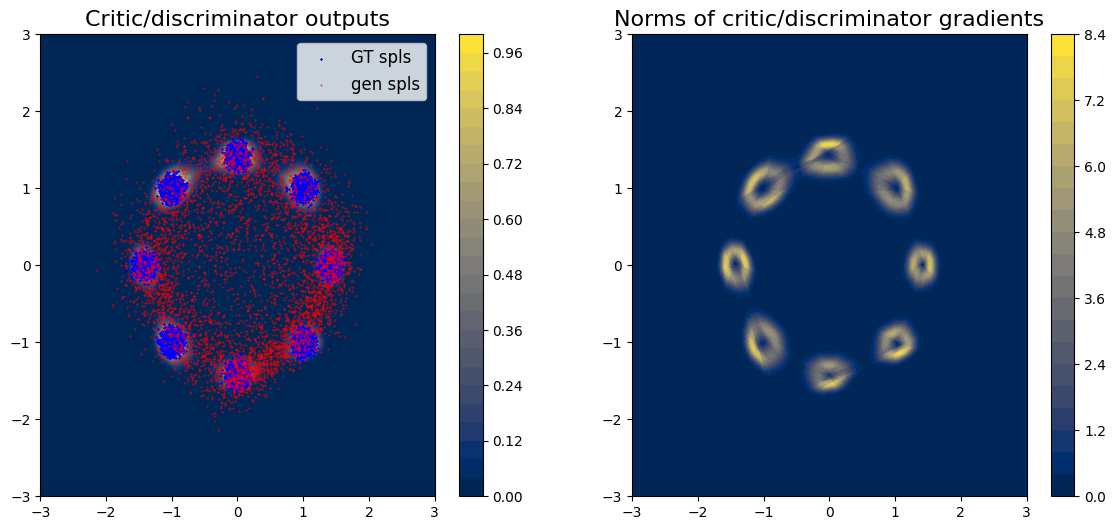

 20%|██████████████████████████▍                                                                                                         | 200/1000 [00:42<02:39,  5.01it/s]

Epoch 200


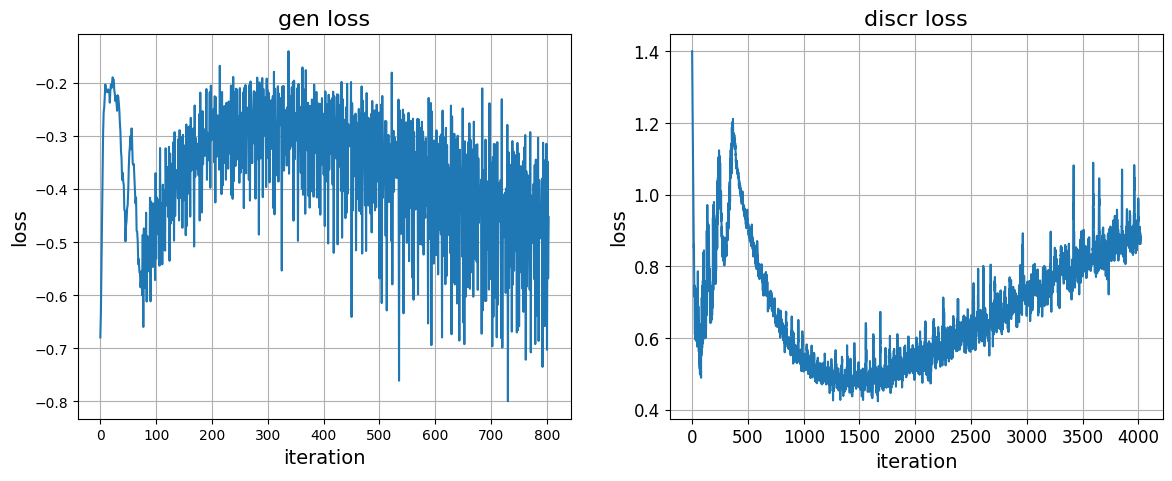

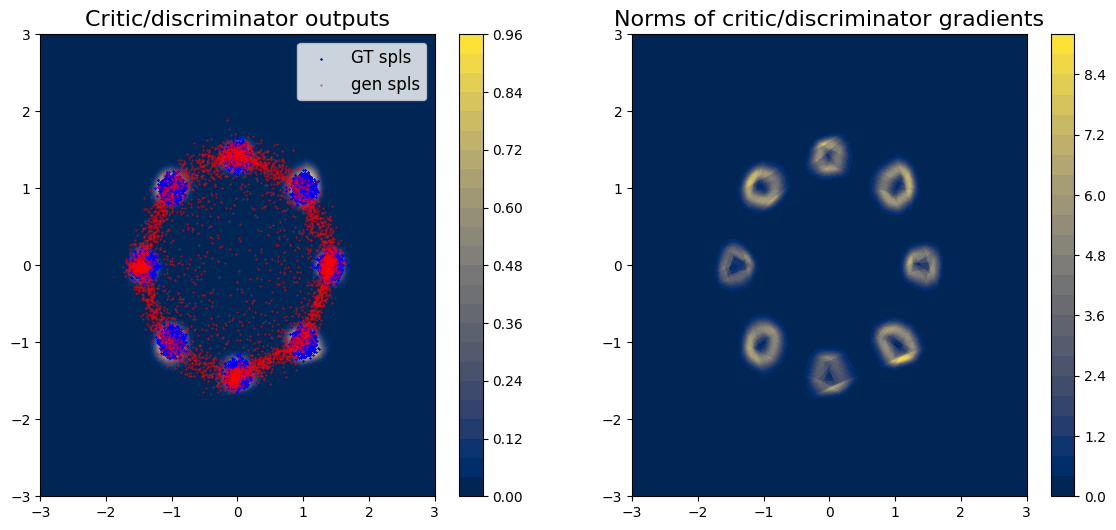

 30%|███████████████████████████████████████▌                                                                                            | 300/1000 [01:05<02:16,  5.12it/s]

Epoch 300


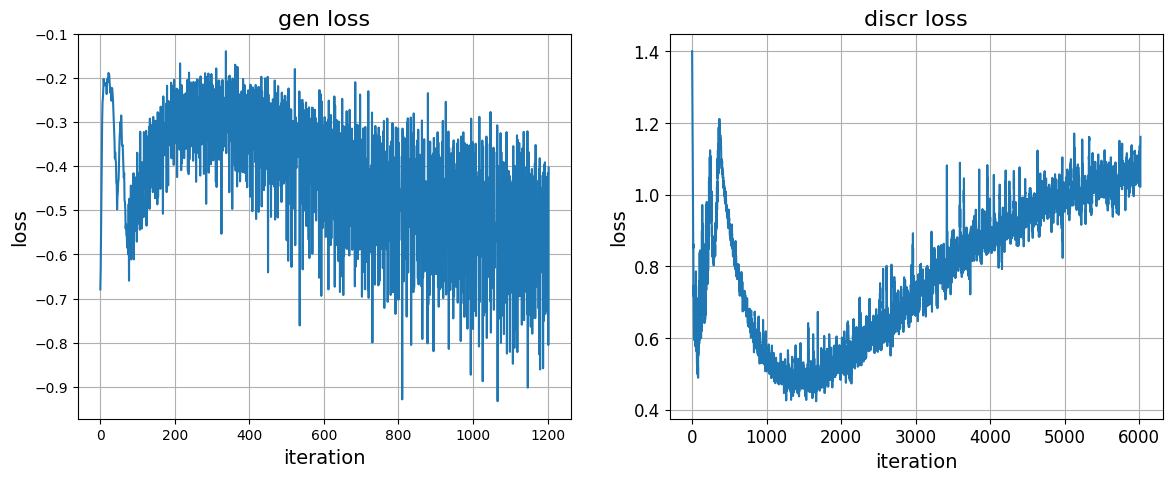

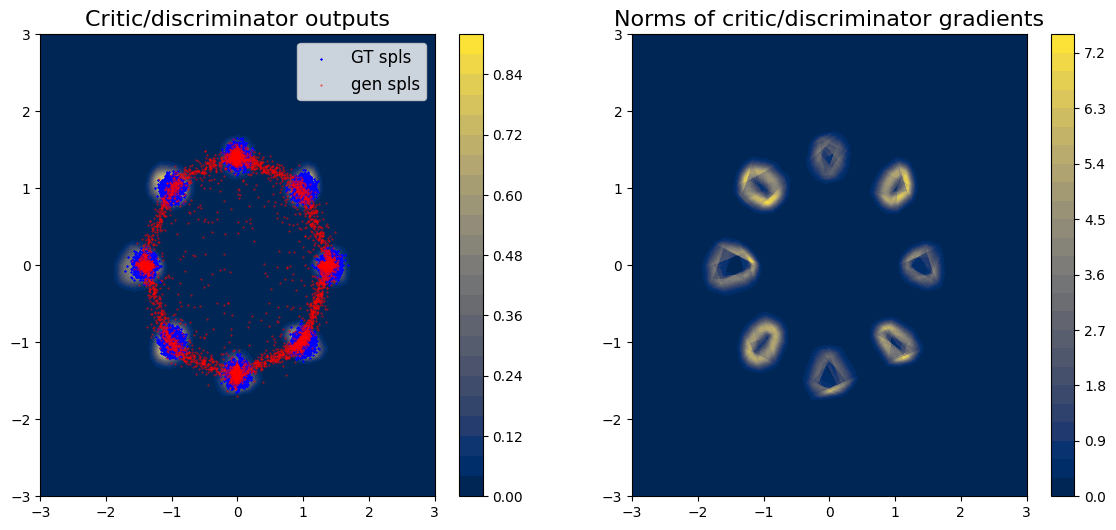

 40%|████████████████████████████████████████████████████▊                                                                               | 400/1000 [01:27<01:58,  5.06it/s]

Epoch 400


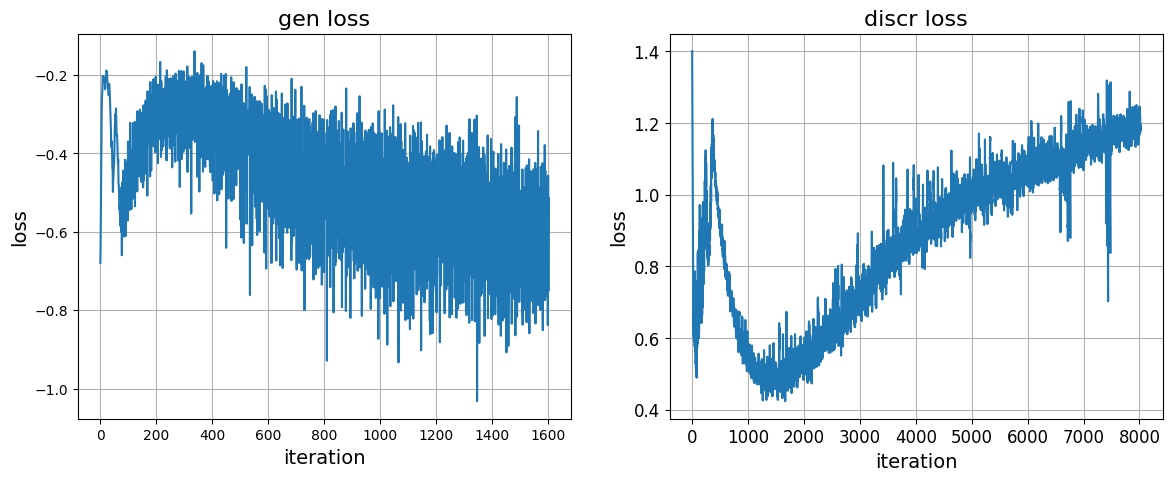

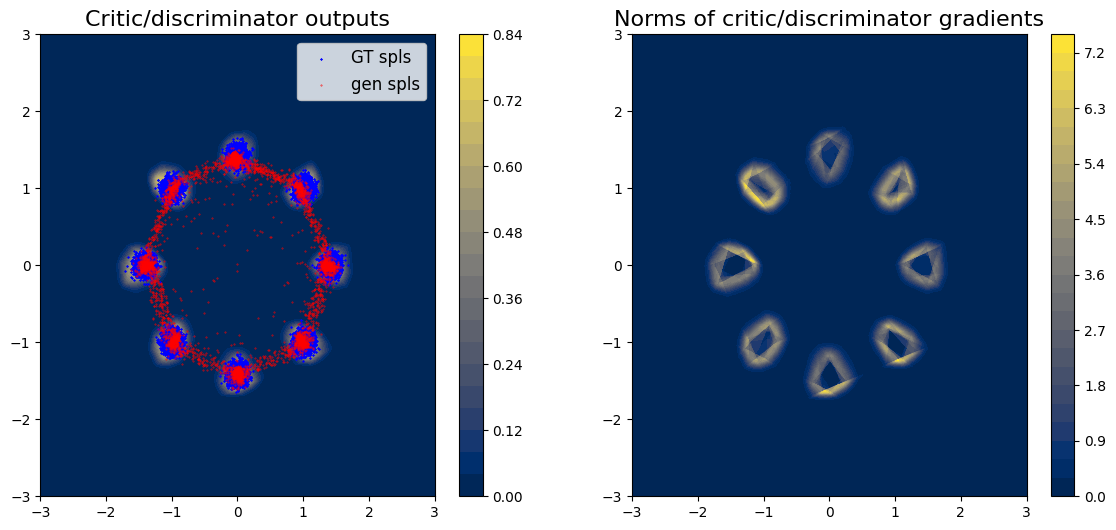

 50%|██████████████████████████████████████████████████████████████████                                                                  | 500/1000 [01:49<01:40,  4.98it/s]

Epoch 500


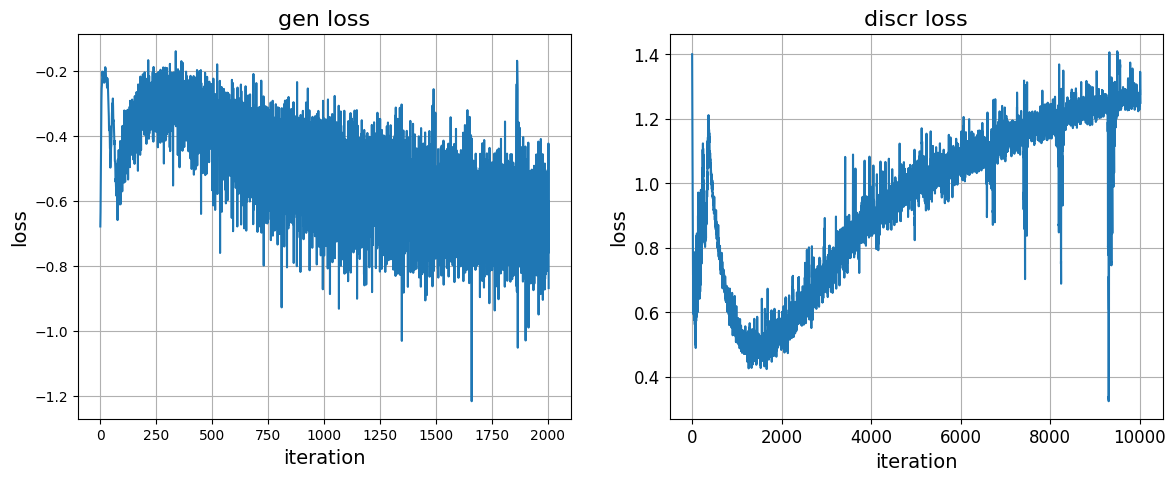

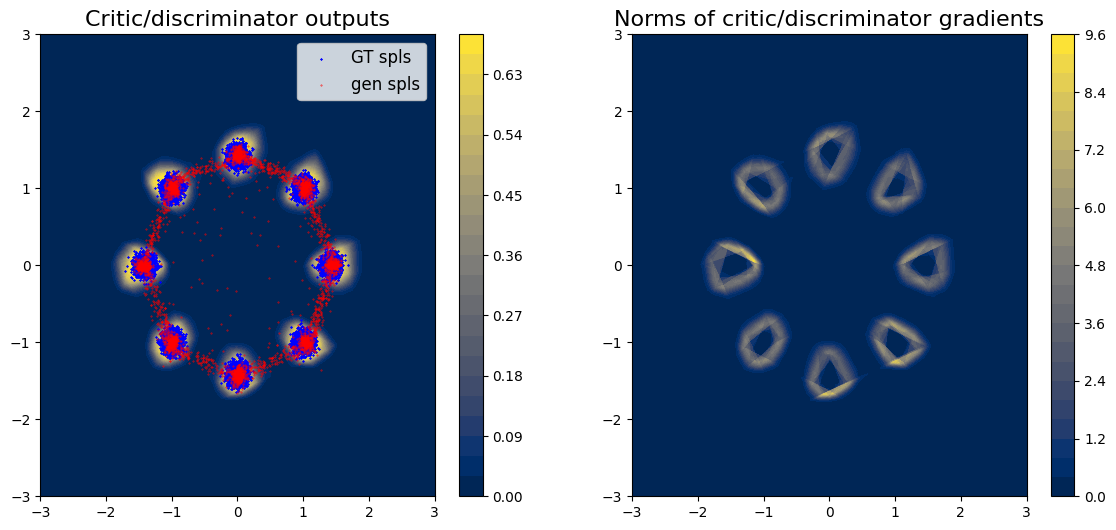

 60%|███████████████████████████████████████████████████████████████████████████████▏                                                    | 600/1000 [02:12<01:17,  5.17it/s]

Epoch 600


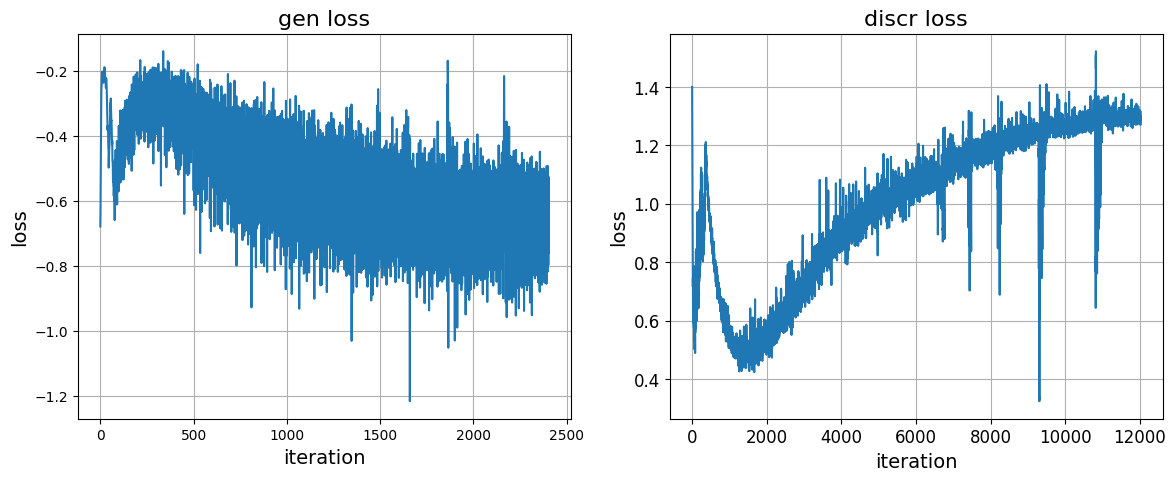

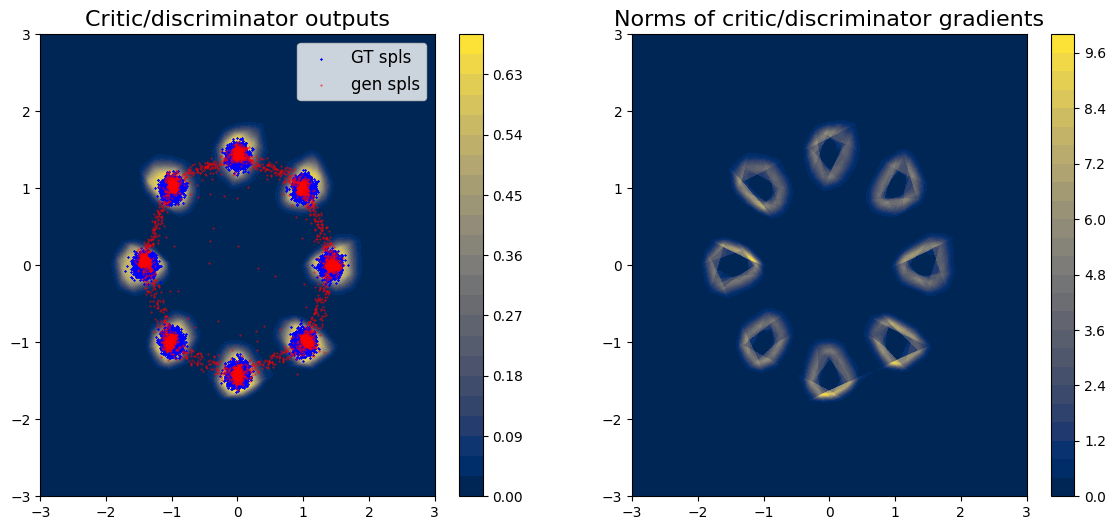

 70%|████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 700/1000 [02:33<00:59,  5.04it/s]

Epoch 700


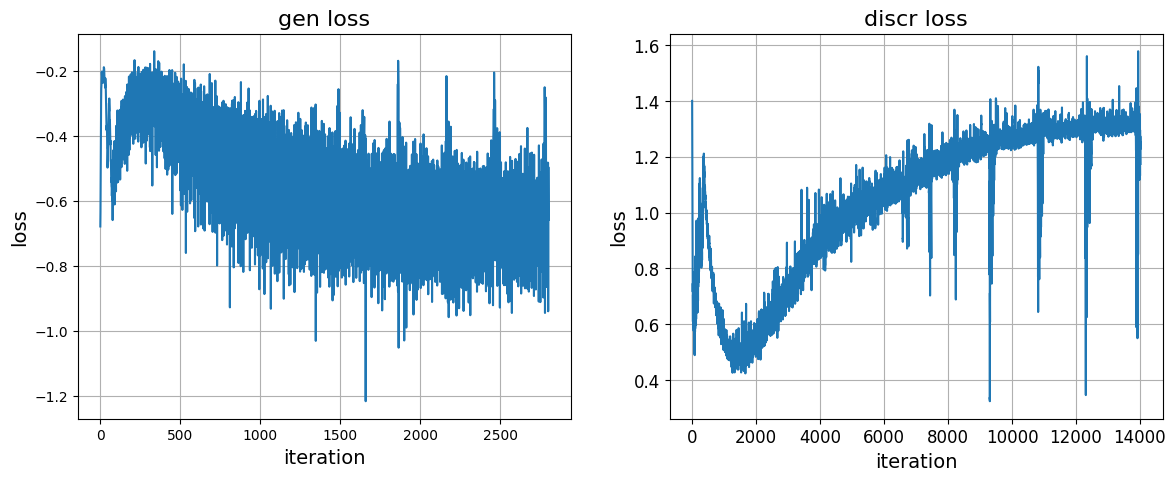

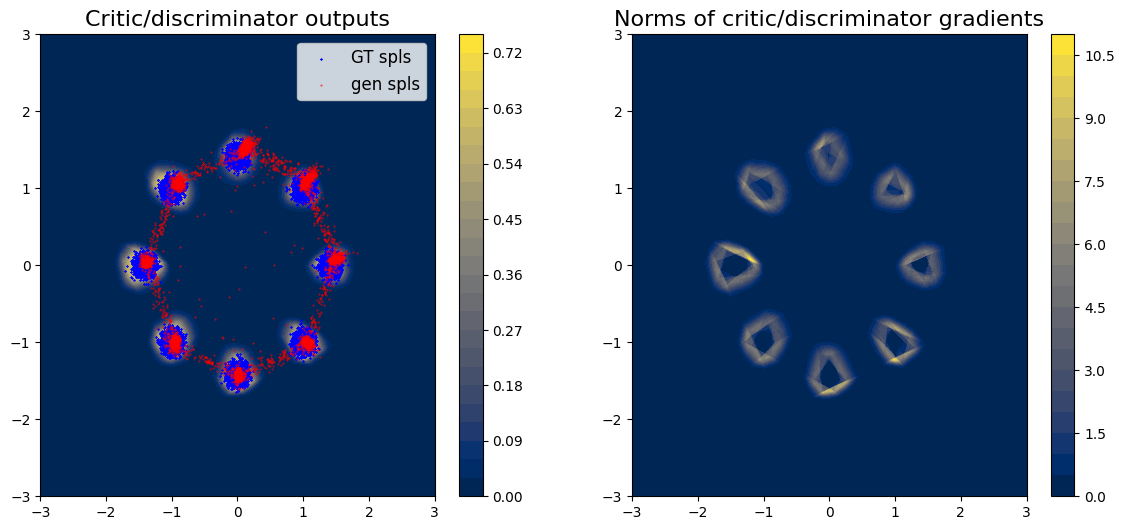

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 800/1000 [02:55<00:39,  5.04it/s]

Epoch 800


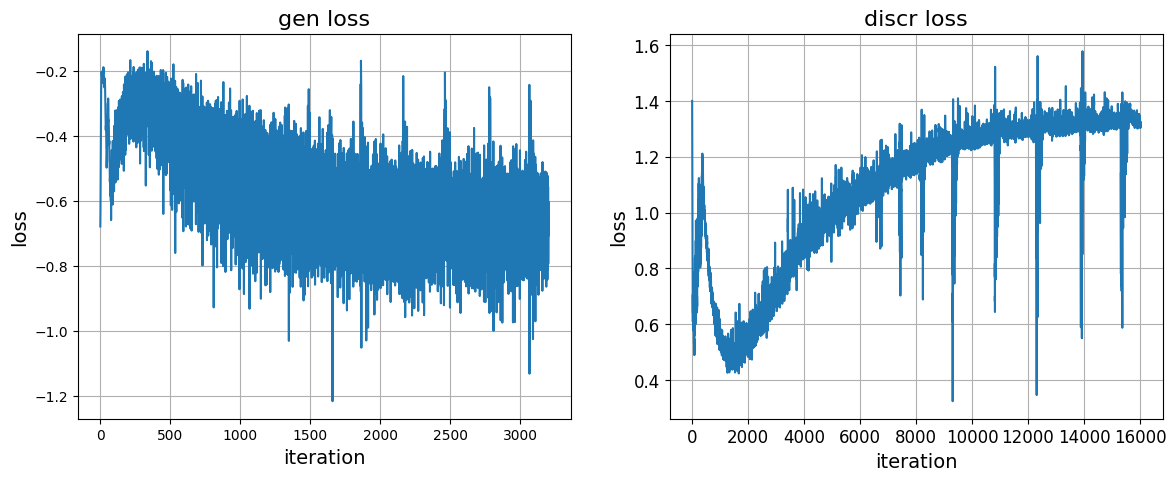

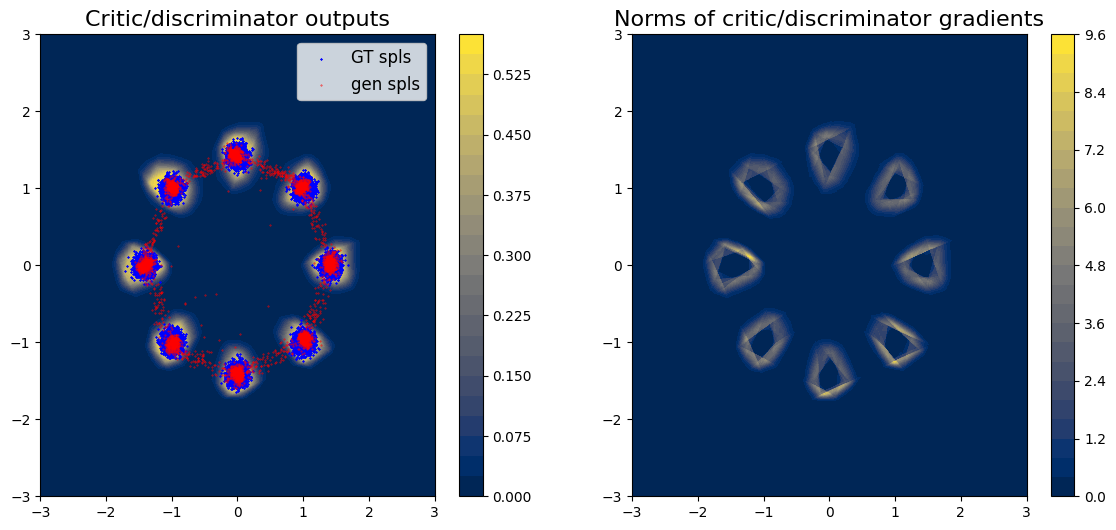

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 900/1000 [03:17<00:18,  5.44it/s]

Epoch 900


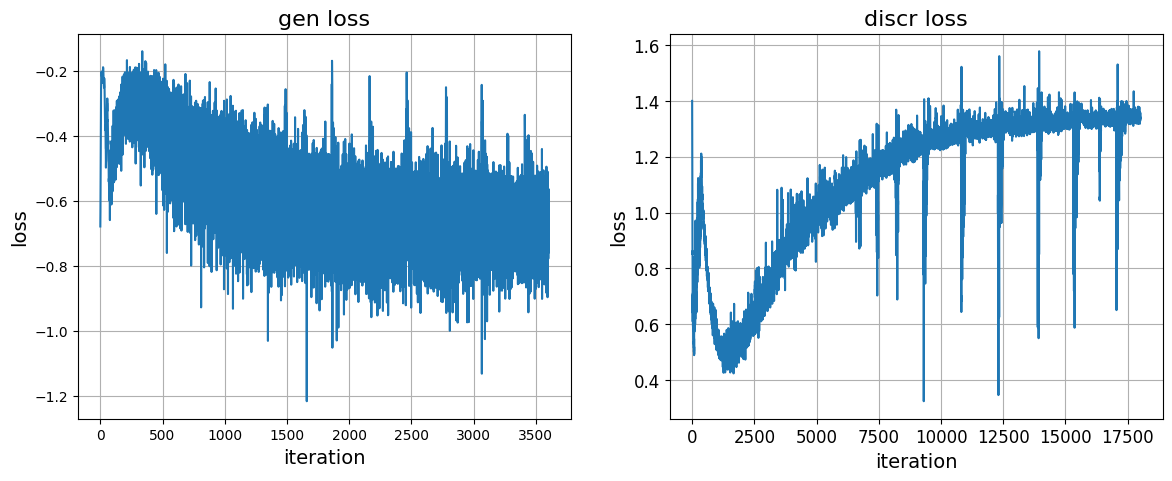

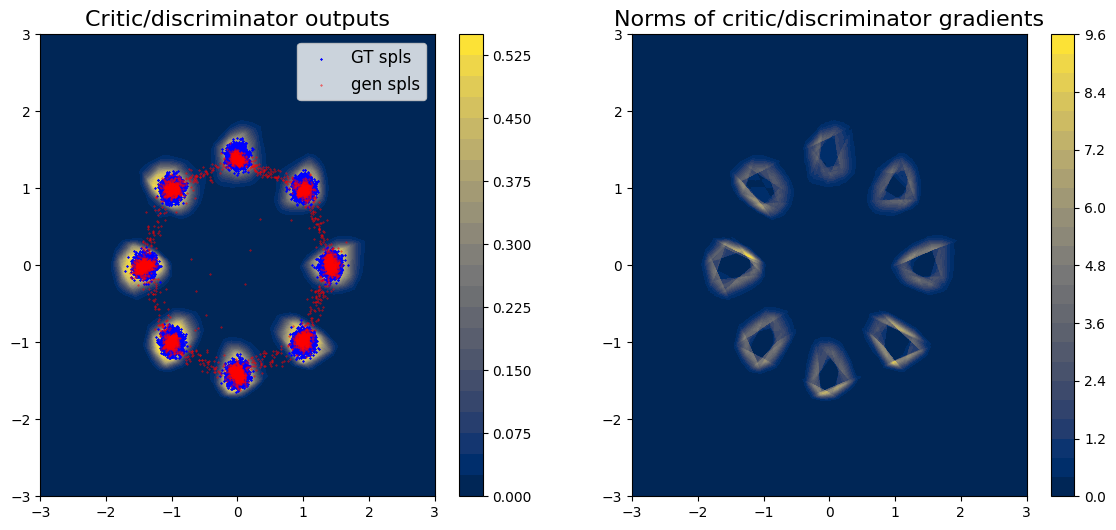

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:38<00:00,  4.57it/s]


In [ ]:
BATCH_SIZE = 1024
GEN_HIDDENS = [128, 128, 128]
DISCR_HIDDENS = [128, 128, 128]
DISCRIMINATOR_STEPS = 5 # 5- good, 15-mode not covered
LR = 2e-4 # < 1e-2
N_EPOCHS = 1000 # change it if you want

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

G = VanillaGenerator(16, GEN_HIDDENS, 2).to(DEVICE)
D = VanillaDiscriminator(2, DISCR_HIDDENS, 1).to(DEVICE)
G_optim = torch.optim.RMSprop(G.parameters(), lr=LR)
D_optim = torch.optim.RMSprop(D.parameters(), lr=LR)
diagnostic = GANDiagnosticCompanion2D(G, D, train_data)

train_losses = train_vanilla(
    train_loader,
    G,
    D,
    G_optim,
    D_optim,
    discriminator_steps=DISCRIMINATOR_STEPS,
    n_epochs=N_EPOCHS,
    diagnostic=diagnostic,
    visualize_steps=100
)

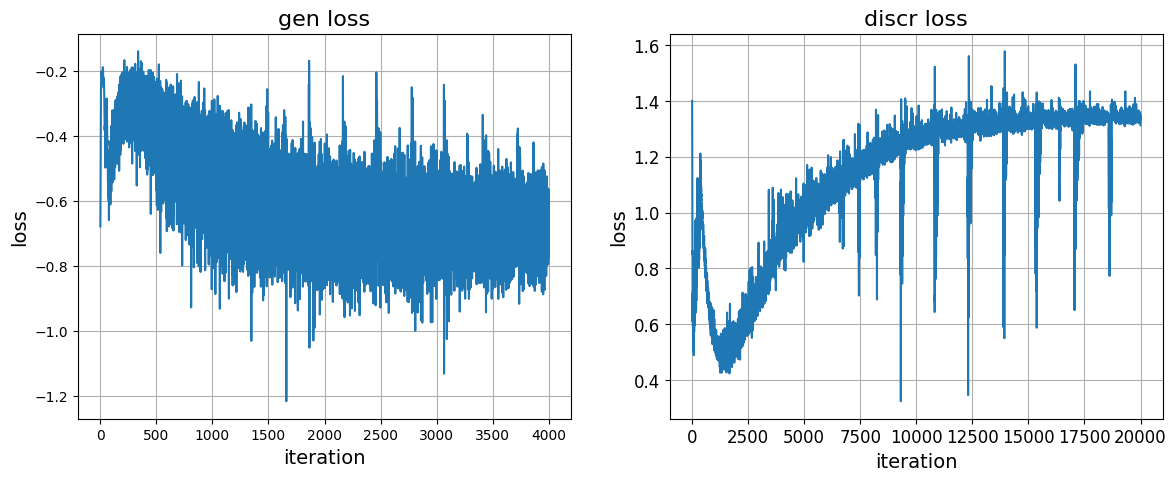

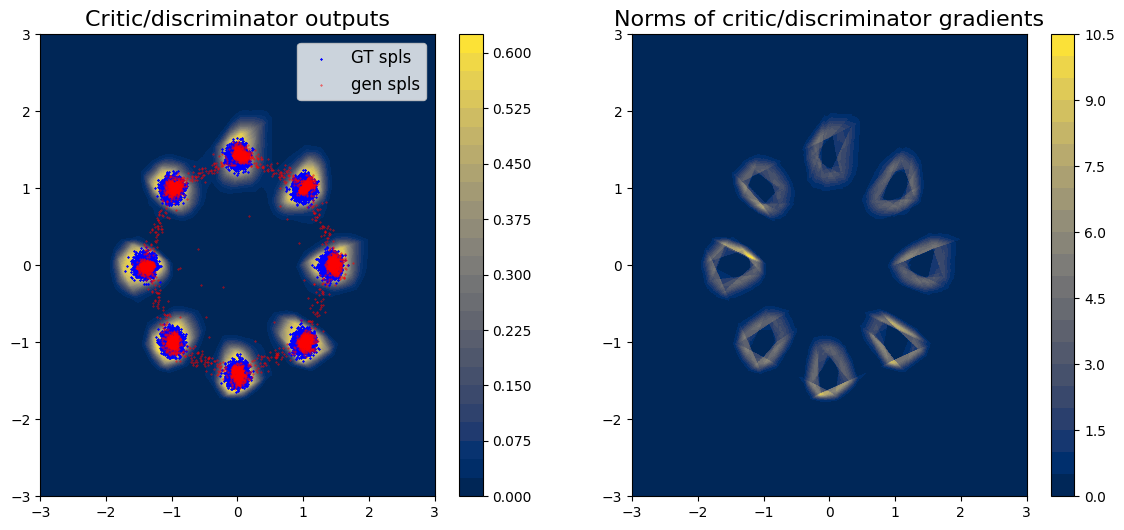

In [ ]:
diagnostic.visualize()

#### Vanishing gradient problem [ saturation of $\log(1 - D(G(z))$ ]

See *Towards Principled Methods for Training Generative Adversarial Networks* [paper](https://arxiv.org/abs/1701.04862) by *Martin Arjovsky* for more details.

**Problem 1.** When generated distribution $p(x \vert \theta)$ and reference distribution $\mathbb{P}$ have disjoint compact supports (there are even softer conditions), then the perfect discriminator $D^* : \mathbb{R}^{D_x} \rightarrow [0, 1]$ (which maximizes $V(G_\theta, D)$) will perfectly distinguish generated and real samples and $\nabla_x D^*(x) = 0$ for $x \sim \mathbb{P}$ or $x\sim p(x \vert \theta)$

* <span style="color:red">$\Rightarrow$ any learning will stop!</span>

* <u>At the beginning of GAN training</u> it is typical that $p(x \vert \theta)$ <u>is not aligned</u> with $\mathbb{P}$. <span style="color:red">$\Rightarrow$ learning may stuck if the discriminator is sub-optimal.</span>

<center>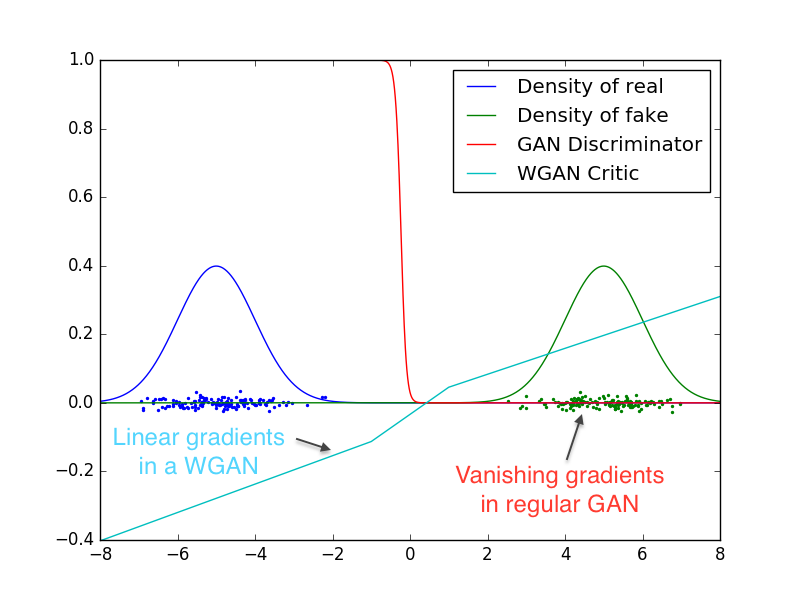</center>

* <span style="color:green">We will fix this problem later.</span>

**Problem 2.** (particular conclusion of *Problem 1.*). In the conditions of *Problem 1.*:

$$ \lim\limits_{\Vert D - D^*\Vert \rightarrow 0} \nabla_{\theta} \big\{\mathbb{E}_{z \sim p_z(z)} \log(1 - D(G_{\theta}(z)))\big\} = 0,$$
i.e., if $p(x \vert \theta)$ is not aligned with $\mathbb{P}$ then the closer discriminator $D$ to the optimal one $D^*$ the weaker the gradient of the objective $V(G_\theta, D)$ w.r.t. $\theta$ and the slower the optimization of the generator $G_\theta$. This effect is known as __saturation__ of $\log(1 - D(G(z))$.

<center>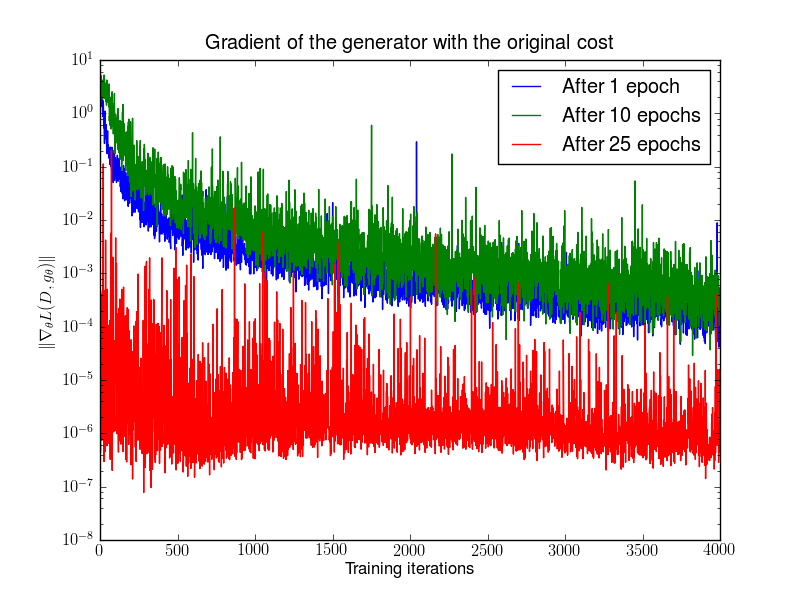</center>

### 2.2 Non-saturating GAN ("fixes" Problem 2)

#### NS-GAN discriminator optimization

The same as **Vanilla GAN** disciminator optimization

-----------

#### NS-GAN generator optimization

**Vanilla GAN** generator $G$ gradient step update (for current distriminator $D$):

$$\theta_{\text{new}} = \theta_{\text{old}} - \gamma \nabla_{\theta} \big[\mathbb{E}_{z \sim p_z(z)} \log(1 - D(G_{\theta}(z)))\big]\Big|_{\theta = \theta_{\text{old}}}$$

(this corresponds to minimization of $\mathbb{E}_{z \sim p_z(z)} \log(1 - D(G_{\theta}(z)))$ w.r.t. $\theta$)

**Non-saturating GAN** generator $G$ gradient step update (for current distriminator $D$):

$$\theta_{\text{new}} = \theta_{\text{old}} + \gamma \nabla_{\theta} \big[\mathbb{E}_{z \sim p_z(z)} \log(D(G_{\theta}(z)))\big]\Big|_{\theta = \theta_{\text{old}}}$$

(this corresponds to <u>maximization</u> of $\mathbb{E}_{z \sim p_z(z)} \log(D(G_{\theta}(z)))$ w.r.t. $\theta$)

* <span style="color:green">Gradients became __much stronger__</span>

<center>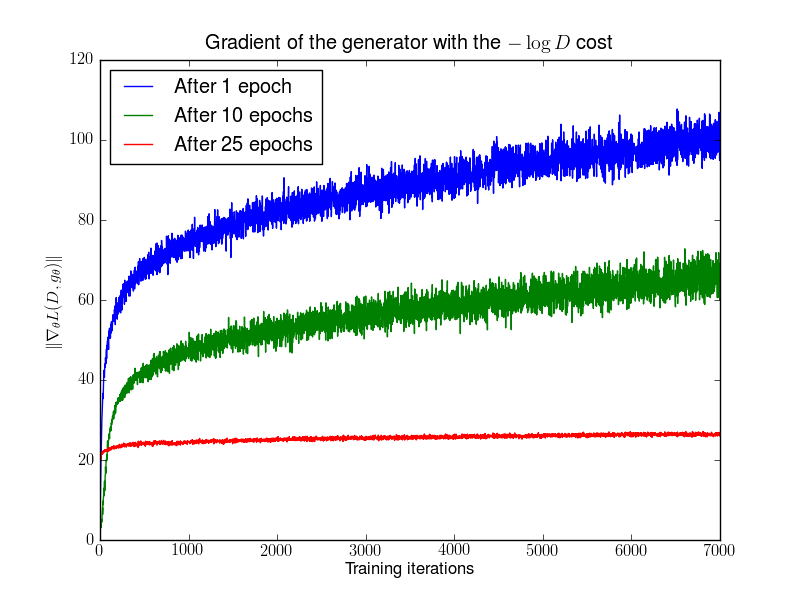</center>

* <span style="color:red">Less stable training</span>

#### Practical aspects of NS GAN

* When implementing `Vanilla GAN` discriminator $D$ we apply `Sigmoid` after the final layer:

$$
\sigma(x) = \frac{1}{1 + e^{-x}}
$$

* Let us instead parameterize `NS GAN` discriminator $D$ as arbitrary function $D : \mathbb{R}^{D_x} \rightarrow \mathbb{R}$ by explicitly introducing the `Sigmoid` in the loss function.

❔ **Exercise**: Prove that optimization steps for the discriminator and the generator of `NS GAN` are as follows:

💡 **Hint:** Recall that $\text{Softplus}(x) = \log(1 + \exp(x))$. Use the fact: $\sigma(-x) = 1 - \sigma(x)$.

*Note*: In what follows, **discriminator** $D_{\phi}$ is an <u>arbitrary MLP</u> (not restricted to produce numbers in $[0, 1]$ interval)!

1. **D** update:

$$
\text{loss}_{D_{\phi}} = \frac{1}{\vert X_{B} \vert} \sum\limits_{x \in X_B} \text{Softplus}(-D_{\phi}(x)) +  \frac{1}{\vert Z_B \vert} \sum\limits_{z \in Z_B} \text{Softplus}(D_{\phi}(G_{\theta}(z)))  \rightarrow \min_{\phi}
$$

2. **G** update:

$$
\text{loss}_{G_{\theta}} =  \frac{1}{\vert Z_B \vert} \sum\limits_{z \in Z_B} \text{Softplus}(-D_{\phi}(G_{\theta}(z)))  \rightarrow \min_{\theta}
$$

#### Implementing NS GAN

Define the `NS GAN` <b>generator</b> $G :\mathbb{R}^{D_z}\rightarrow \mathbb{R}^{2}$ and <b>discriminator</b> $D : \mathbb{R}^{2}\rightarrow \mathbb{R}$

* You do not need to restrict the discriminator's output to be in range $[0, 1]$.

In [ ]:
class NSGenerator(VanillaGenerator):
    pass

GEN_HIDDENS = [128, 128, 128]

G = NSGenerator(2, GEN_HIDDENS, 2).to(DEVICE)

class NSDiscriminator(FullyConnectedMLP):
    pass

DISCR_HIDDENS = [128, 128, 128]

D = NSDiscriminator(2, DISCR_HIDDENS, 1).to(DEVICE)

#### Implementing NS GAN Loss

Implement `NS GAN` <b>generator</b> training step.

* The function below should compute the stocastic estimate of Non-saturating GAN generator loss $\frac{1}{\vert Z_B \vert} \sum\limits_{z \in Z_B} \text{Softplus}(-D_{\phi}(G_{\theta}(z)))$, $Z_B \sim p_z$ and perform a single gradient descent step w.r.t the parameter $\theta$ of the generator.

In [ ]:
def ns_gen_step(
    X : torch.Tensor, # random batch from the dataset
    G : nn.Module, # generator model
    D : nn.Module, # discriminator model
    G_optim : torch.optim.Optimizer, # optimizer for generator (Adam/RMSprop/SGD etc.)
) -> torch.Tensor: # returns the value of loss to track the training statistics
    G.train()
    D.eval()
    batch_size = X.size(0)
    X_gen = G.sample(batch_size)
    scores_gen = D(X_gen)
    loss = F.softplus(-scores_gen).mean()
    G_optim.zero_grad()
    loss.backward()
    G_optim.step()
    return loss.item()

#### $R_1$ regularizer (for discriminator)

See [Mescheder et. al.](https://arxiv.org/abs/1801.04406) for more details.

$$R_1(D_\phi) = \mathbb{E}_{x \sim \mathbb{P}} \big[\Vert \nabla_x D_\phi(x) \Vert^2\big]$$

* The stochastic estimate of $R_1$ value is added with factor $\lambda$ to the discriminator loss:

$$
\text{loss}_{D_{\phi}} = \frac{1}{\vert X_{B} \vert} \sum\limits_{x \in X_B} \text{Softplus}(-D_{\phi}(x)) +  \frac{1}{\vert Z_B \vert} \sum\limits_{z \in Z_B} \text{Softplus}(D_{\phi}(G_{\theta}(z))) + \lambda \frac{1}{\vert X_{B} \vert} \sum\limits_{x \in X_B} \big[\Vert \nabla_x D_\phi(x) \Vert^2\big] \rightarrow \min_{\phi}
$$

* It stabilizes the training. Large and Powerful GAN models, e.g., StyleGAN [paper](https://arxiv.org/abs/1812.04948), utilizes <u>Non-saturating GAN loss with $R_1$ regularizer.

-------

Implement `NS GAN` <b>discriminator</b> training step with **additional $R_1$** regularizer.

* Do not forget to set the `requries_grad` flag of the input data batch (Why?)

* Do not forget to `zero_grad` the discriminator parameters after computing the gradient penalty (Why?)

* 💡 **Hint:** Utilize `torch.Tensor.backward(retain_graph=True, create_graph=True)` function.

❔ What do `retain_graph` and `create_graph` parameters mean? Why do we need to set the to `True`?

In [ ]:
def ns_discr_step(
    X : torch.Tensor, # random batch from the dataset
    G : nn.Module, # generator model
    D : nn.Module, # discriminator model
    D_optim : torch.optim.Optimizer, # optimizer for generator (Adam/RMSprop/SGD etc.)
    r1_regularizer : float = 1., # the factor of R_1 regularization
) -> torch.Tensor: # returns the value of loss to track the training statistics
    G.eval()
    D.train()
    D_optim.zero_grad()
    batch_size = X.size(0)
    with torch.no_grad():
        X_gen = G.sample(batch_size)
    X.requires_grad_()
    scores_gen = D(X_gen)
    scores_real = D(X)
    loss_gen = F.softplus(scores_gen).mean()
    loss_real = F.softplus(-scores_real).mean()
    scores_real.sum().backward(retain_graph=True, create_graph=True)
    gradients = X.grad # the same shape as X
    grad_penalty = (
        gradients.view(gradients.size(0), -1).norm(2, dim=1) ** 2
    ).mean()
    D_optim.zero_grad()
    loss = loss_gen + loss_real + r1_regularizer * grad_penalty

    loss.backward()
    D_optim.step()
    gradients.detach_() # to avoid memory leak!
    return loss.item()

Implement `NS GAN` __training loop__

In [ ]:
def train_ns(
    train_loader : DataLoader, # dataloader of training dataset
    G : nn.Module, # generator model
    D : nn.Module, # discriminator model
    G_optim : torch.optim.Optimizer, # optimizer for the generator
    D_optim : torch.optim.Optimizer, # optimizer for the discriminator
    discriminator_steps : int, # number of discriminators steps per each generator step
    n_epochs : int, # number of training epochs
    diagnostic : GANDiagnosticCompanion, # tracking statistics & visualization
    r1_regularizer : float = 1., # the factor of R_1 regularization for the discriminator training
    visualize_steps : int = 10, # for visualization purposes
) -> None:

    G.train()
    D.train()
    step_i = 0
    for epoch_i in tqdm(range(n_epochs)):
        for batch_i, X in enumerate(train_loader):
            X = X.to(DEVICE)

            # DISCRIMINATOR UPDATE
            d_loss = ns_discr_step(X, G, D, D_optim, r1_regularizer)
            diagnostic.upd_d_loss(d_loss)

            # GENERATOR UPDATE
            if step_i % discriminator_steps == 0:
                g_loss = ns_gen_step(X, G, D, G_optim)
                diagnostic.upd_g_loss(g_loss)
            step_i += 1

        if visualize_steps and epoch_i % visualize_steps == 0:
            print('Epoch {}'.format(epoch_i))
            diagnostic.visualize()

#### NS GAN training

  0%|                                                                                                                                              | 0/1000 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/torch/autograd/__init__.py:200: UserWarning: Using backward() with create_graph=True will create a reference cycle between the parameter and its gradient which can cause a memory leak. We recommend using autograd.grad when creating the graph to avoid this. If you have to use this function, make sure to reset the .grad fields of your parameters to None after use to break the cycle and avoid the leak. (Triggered internally at ../torch/csrc/autograd/engine.cpp:1151.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 0


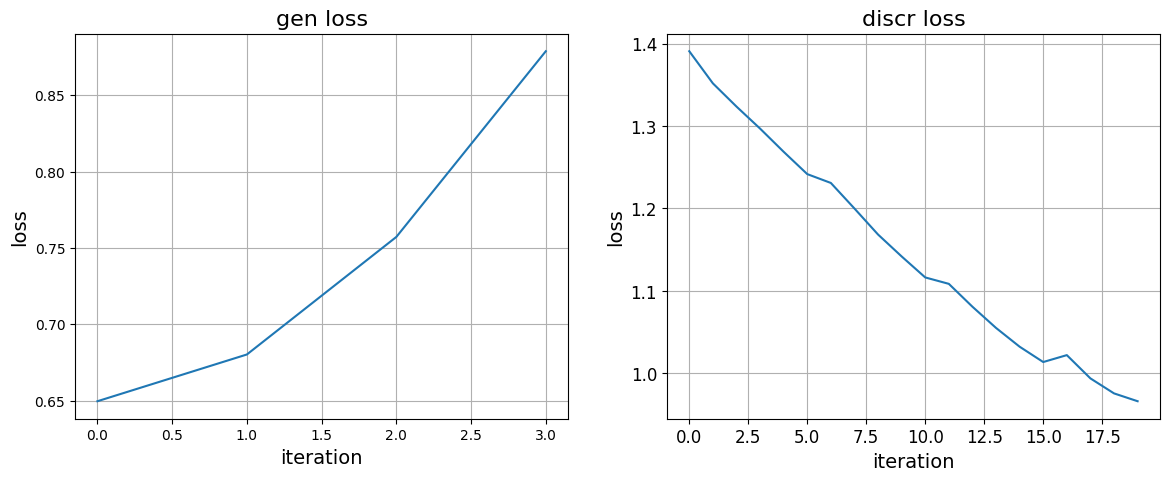

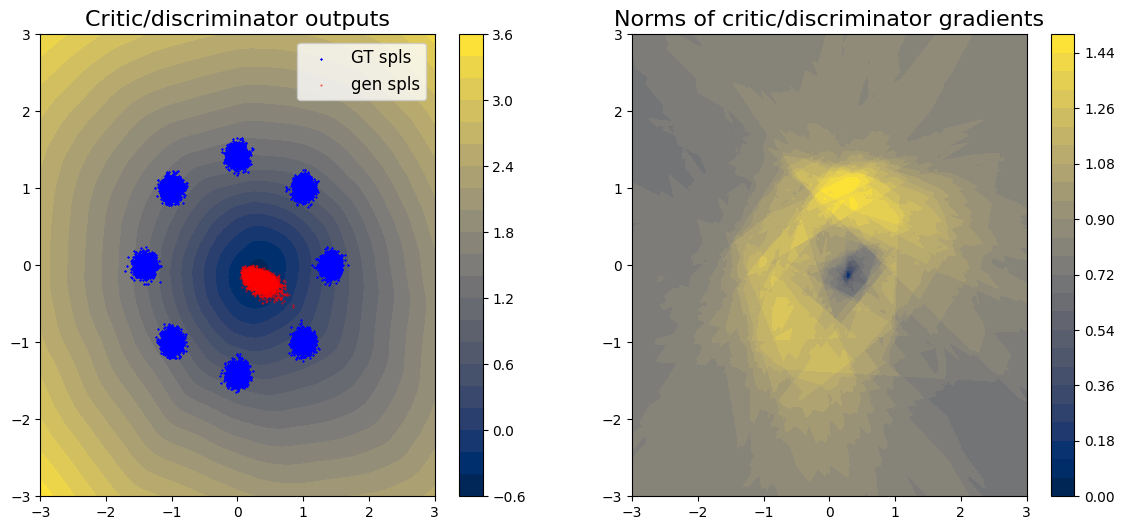

 10%|█████████████▏                                                                                                                      | 100/1000 [00:38<05:40,  2.64it/s]

Epoch 100


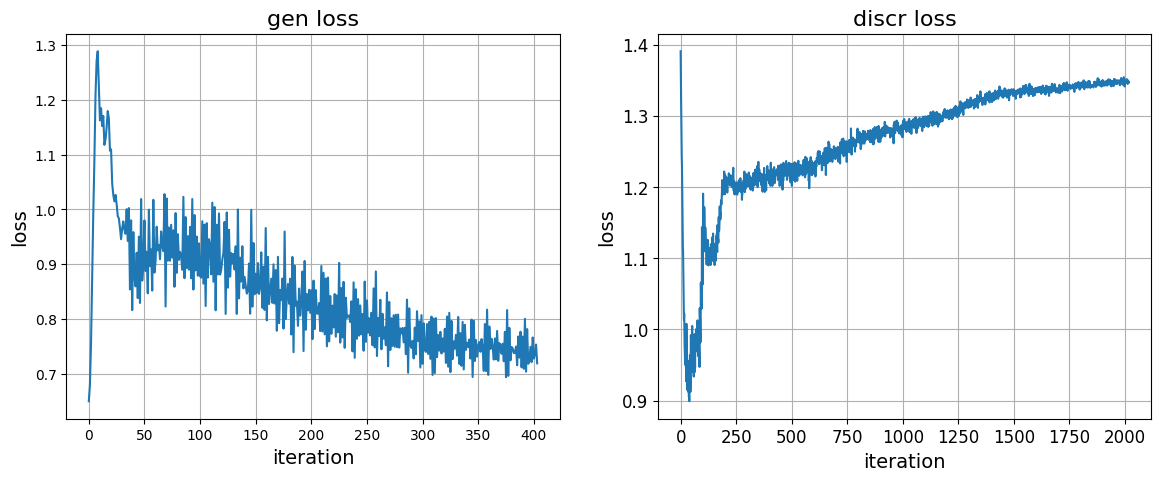

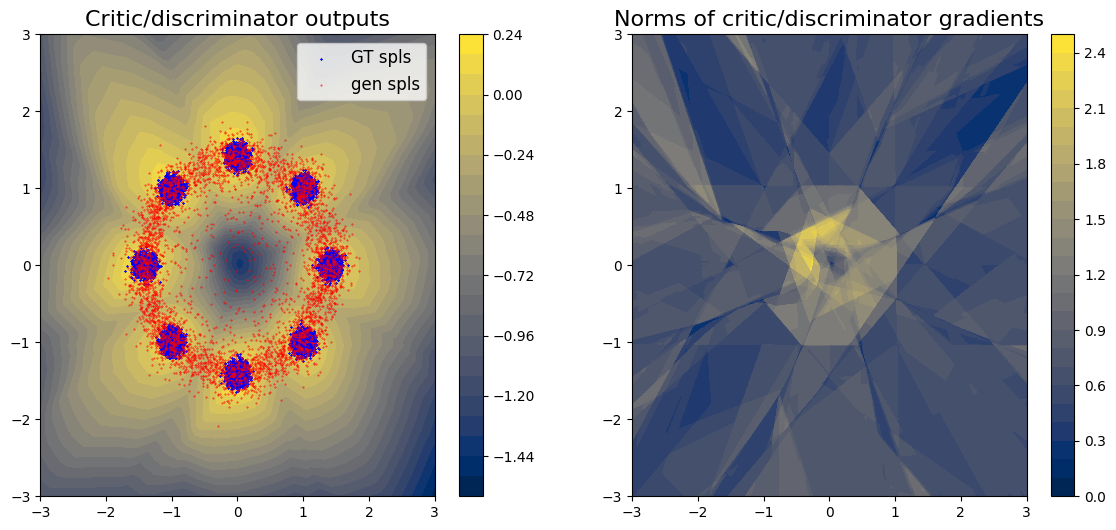

 20%|██████████████████████████▍                                                                                                         | 200/1000 [01:18<05:17,  2.52it/s]

Epoch 200


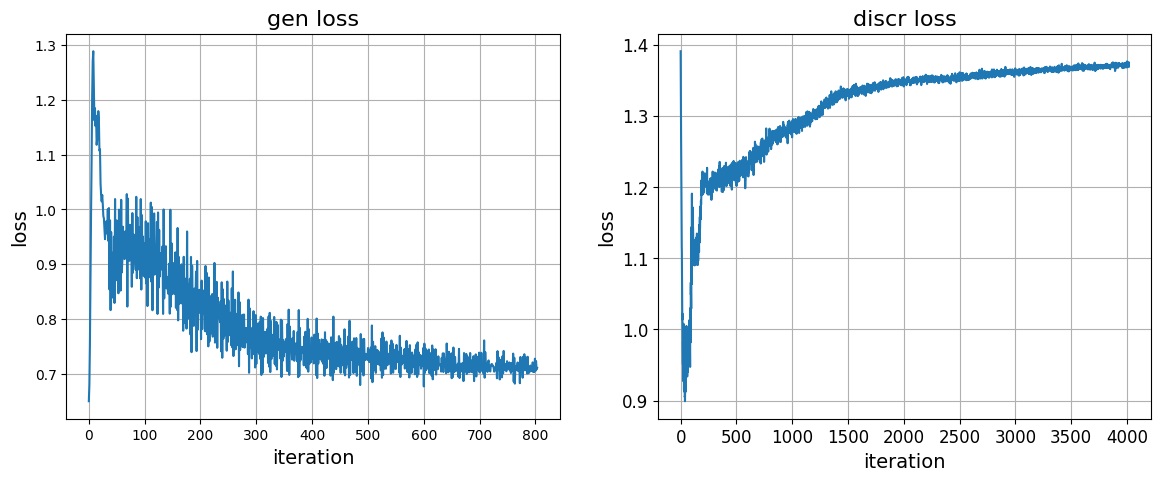

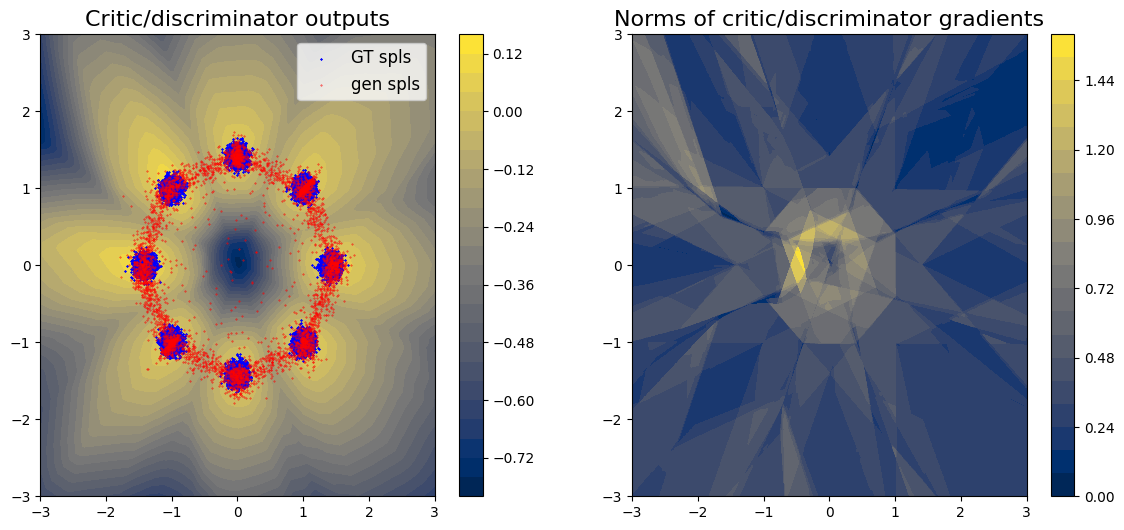

 30%|███████████████████████████████████████▌                                                                                            | 300/1000 [01:57<04:17,  2.72it/s]

Epoch 300


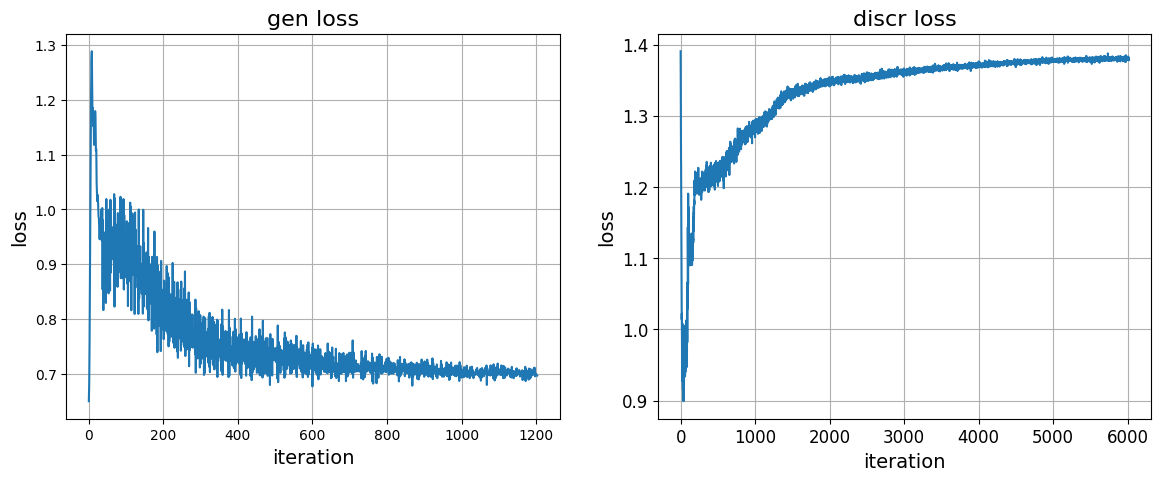

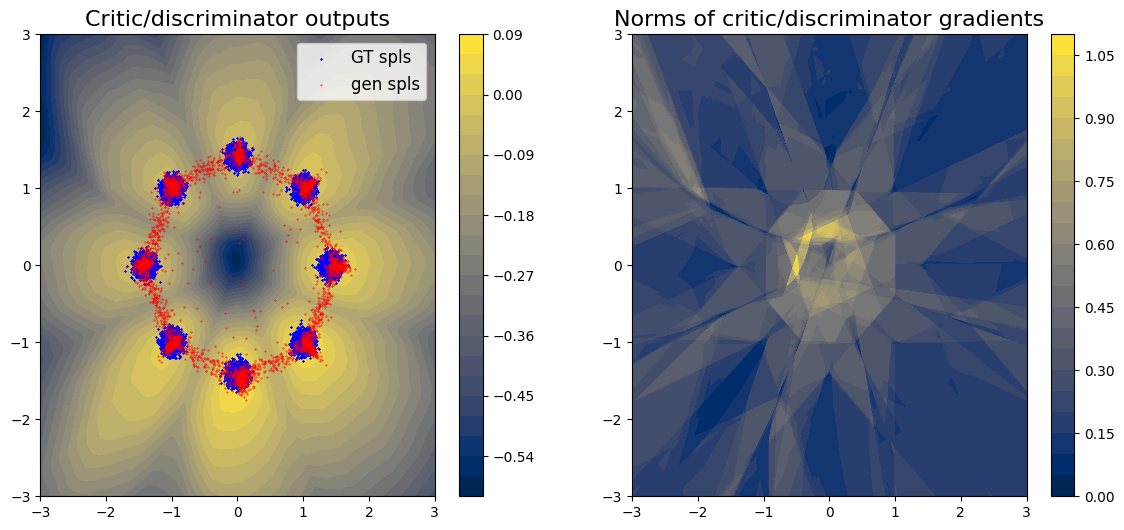

 40%|████████████████████████████████████████████████████▊                                                                               | 400/1000 [02:34<04:06,  2.43it/s]

Epoch 400


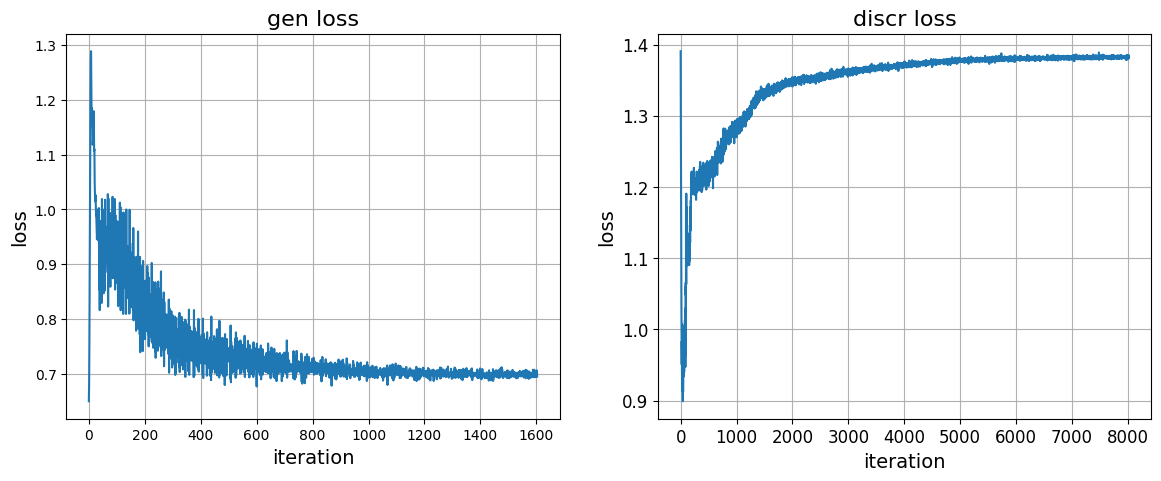

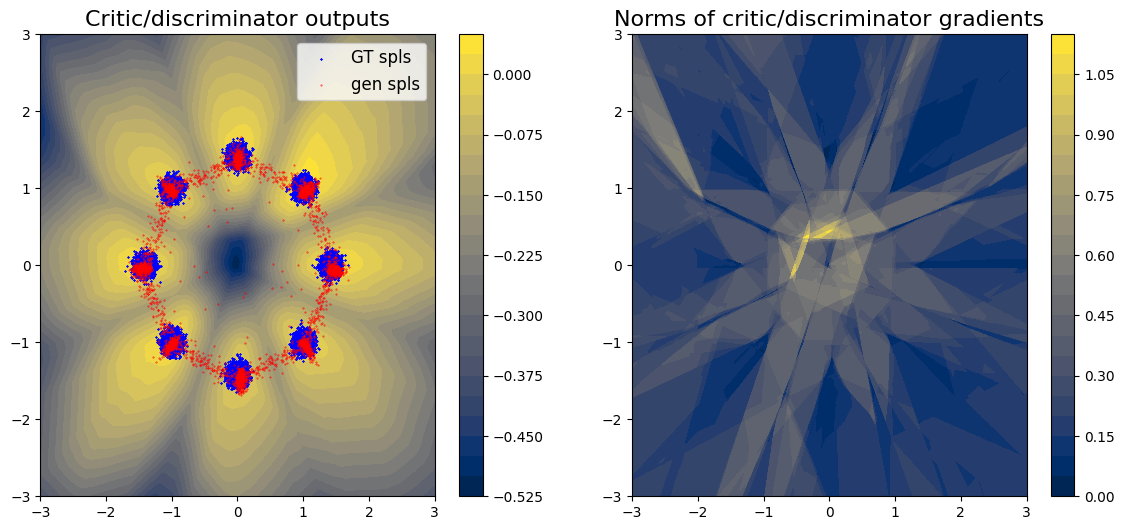

 50%|██████████████████████████████████████████████████████████████████                                                                  | 500/1000 [03:16<03:18,  2.52it/s]

Epoch 500


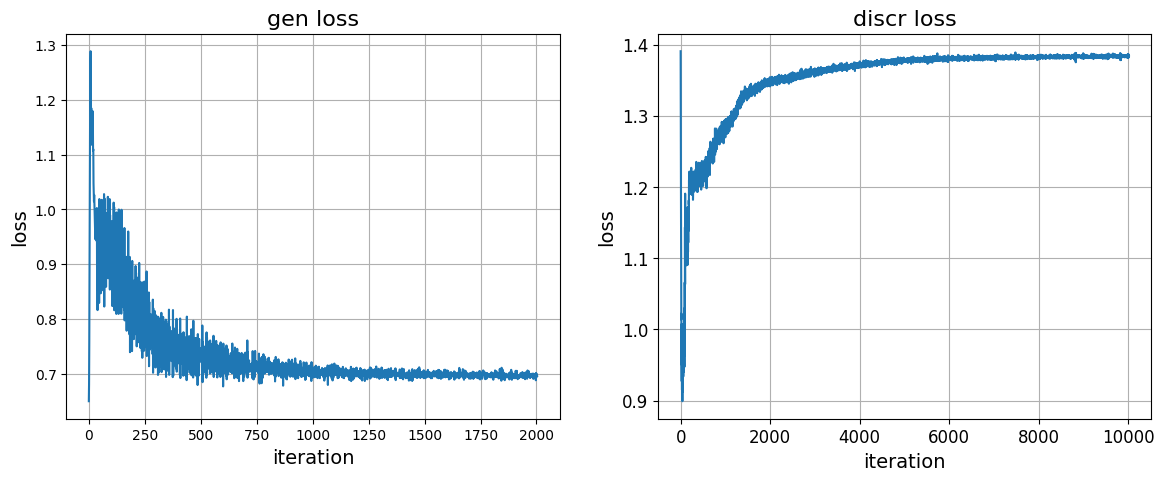

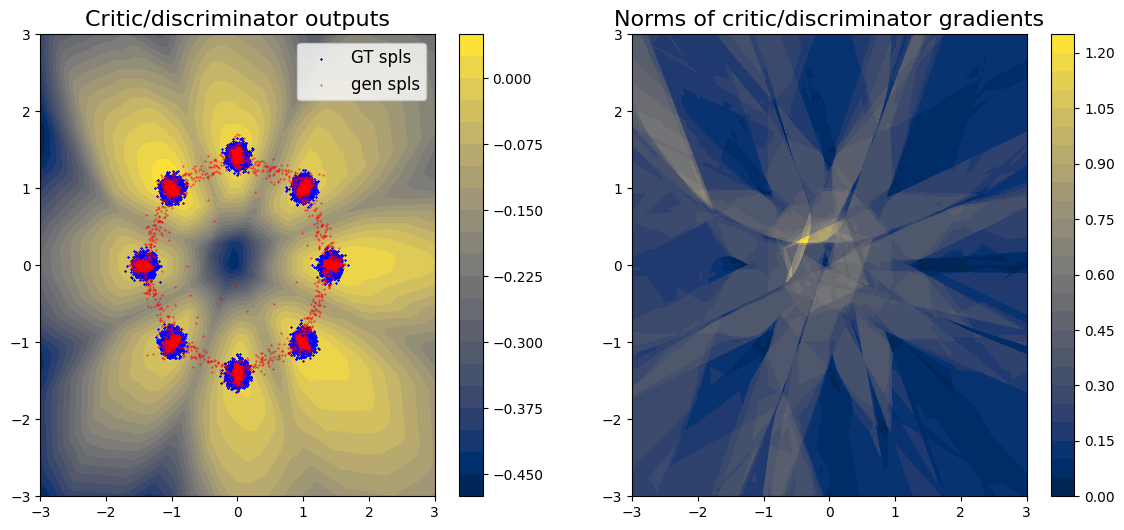

 60%|███████████████████████████████████████████████████████████████████████████████▏                                                    | 600/1000 [03:55<02:32,  2.62it/s]

Epoch 600


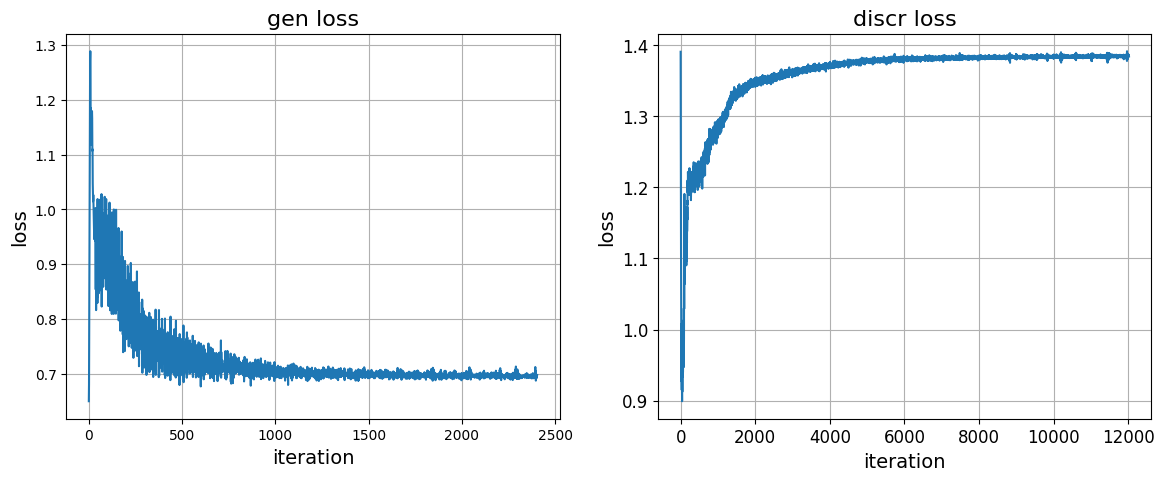

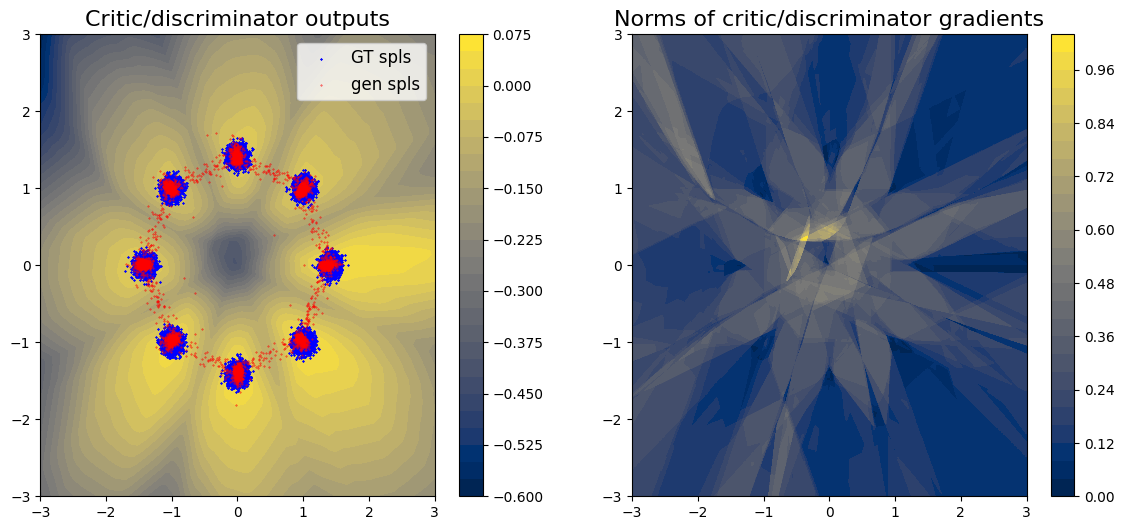

 70%|████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 700/1000 [04:33<01:45,  2.84it/s]

Epoch 700


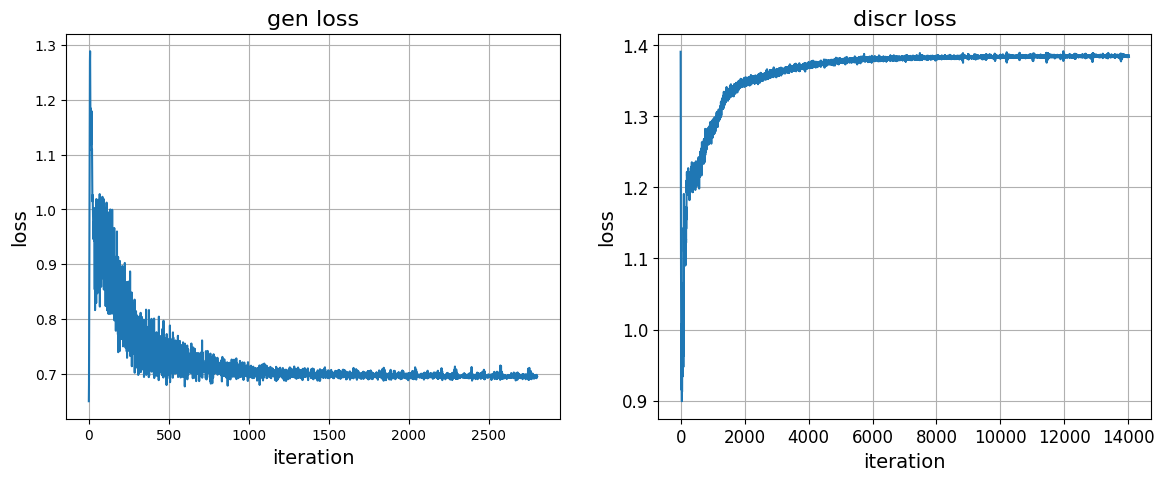

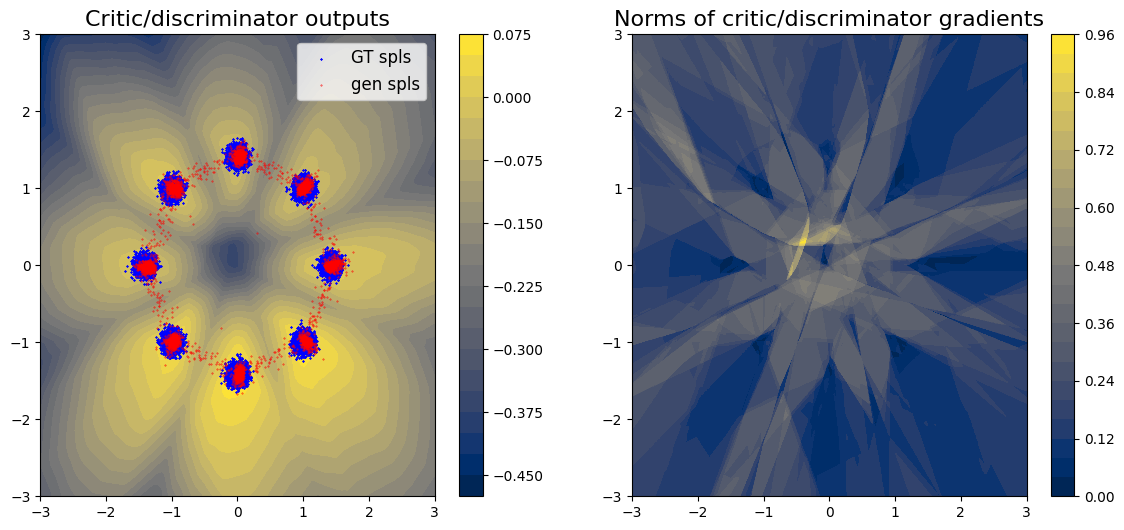

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 800/1000 [05:12<01:15,  2.63it/s]

Epoch 800


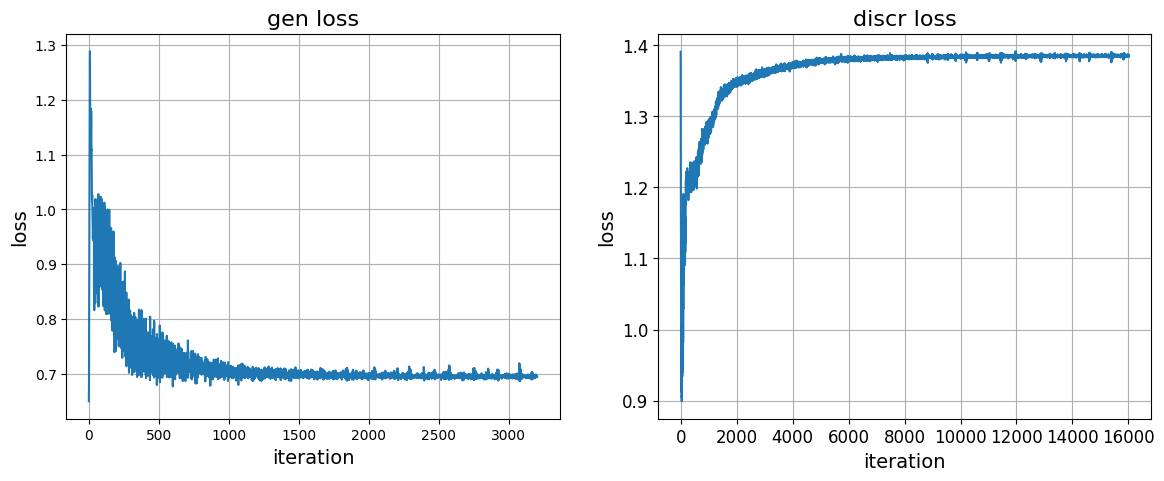

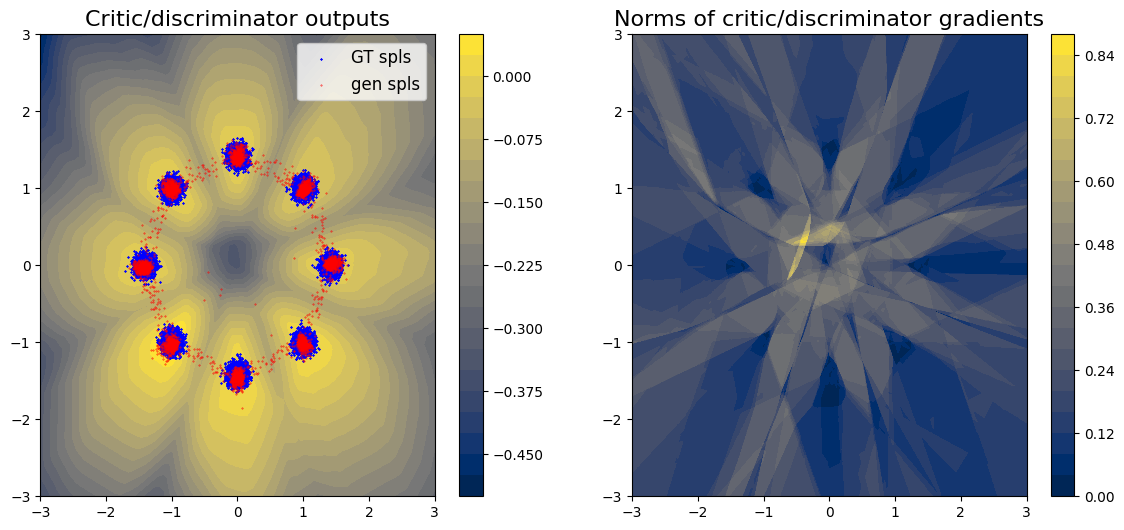

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 900/1000 [05:54<00:38,  2.57it/s]

Epoch 900


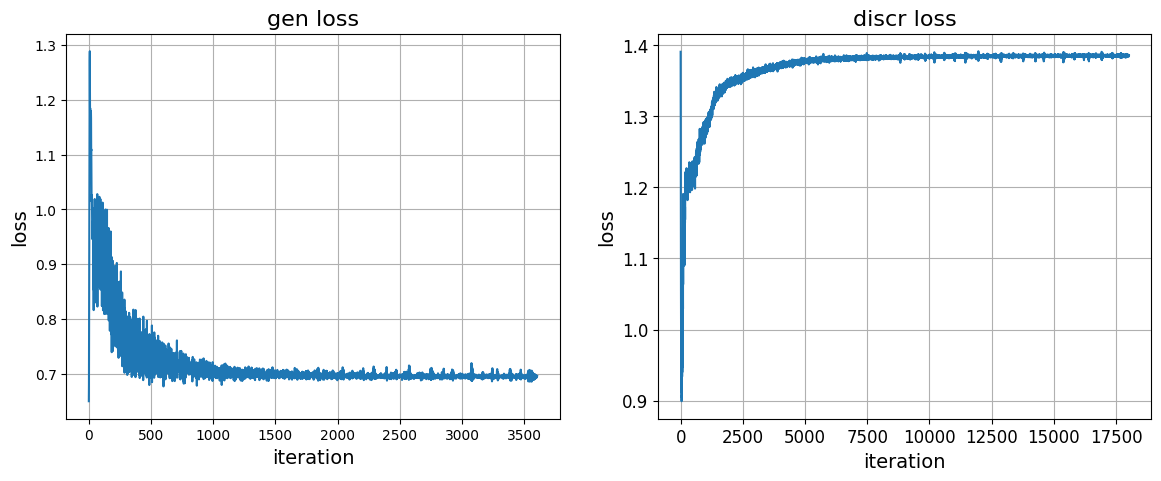

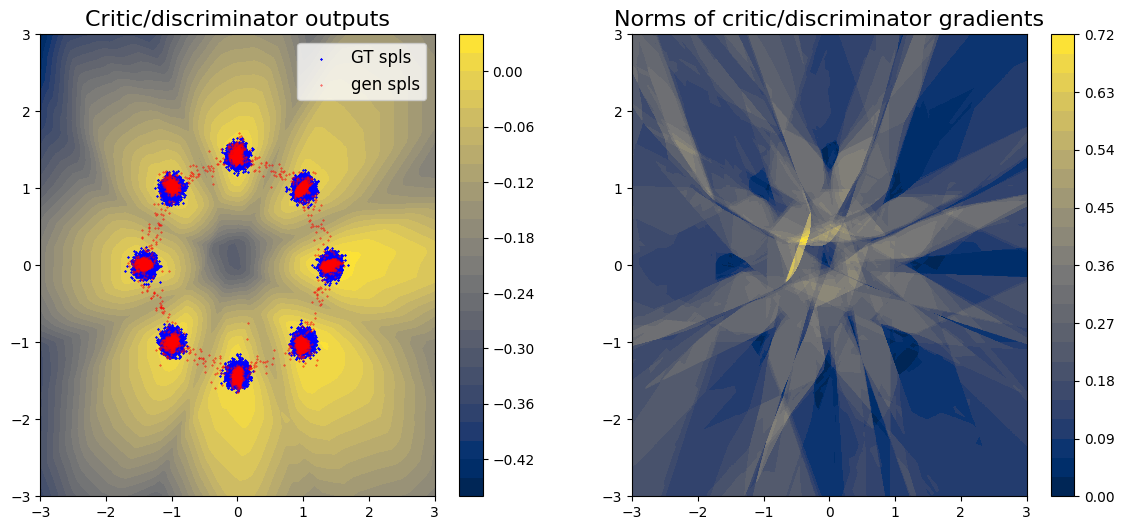

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [06:33<00:00,  2.54it/s]


In [ ]:
BATCH_SIZE = 1024
GEN_HIDDENS = [128, 128, 128]
DISCR_HIDDENS = [128, 128, 128]
DISCRIMINATOR_STEPS = 5 # 2 - more or less, 5 - lose modes
LR = 2e-4 # < 1e-2
R1_REGULARIZER = 0.1
N_EPOCHS = 1000 # change it if you want

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

G = NSGenerator(16, GEN_HIDDENS, 2).to(DEVICE)
D = NSDiscriminator(2, DISCR_HIDDENS, 1).to(DEVICE)
G_optim = torch.optim.RMSprop(G.parameters(), lr=LR)
D_optim = torch.optim.RMSprop(D.parameters(), lr=LR)
diagnostic = GANDiagnosticCompanion2D(G, D, train_data)

train_losses = train_ns(
    train_loader,
    G,
    D,
    G_optim,
    D_optim,
    discriminator_steps=DISCRIMINATOR_STEPS,
    n_epochs=N_EPOCHS,
    diagnostic=diagnostic,
    r1_regularizer=R1_REGULARIZER,
    visualize_steps=100
)

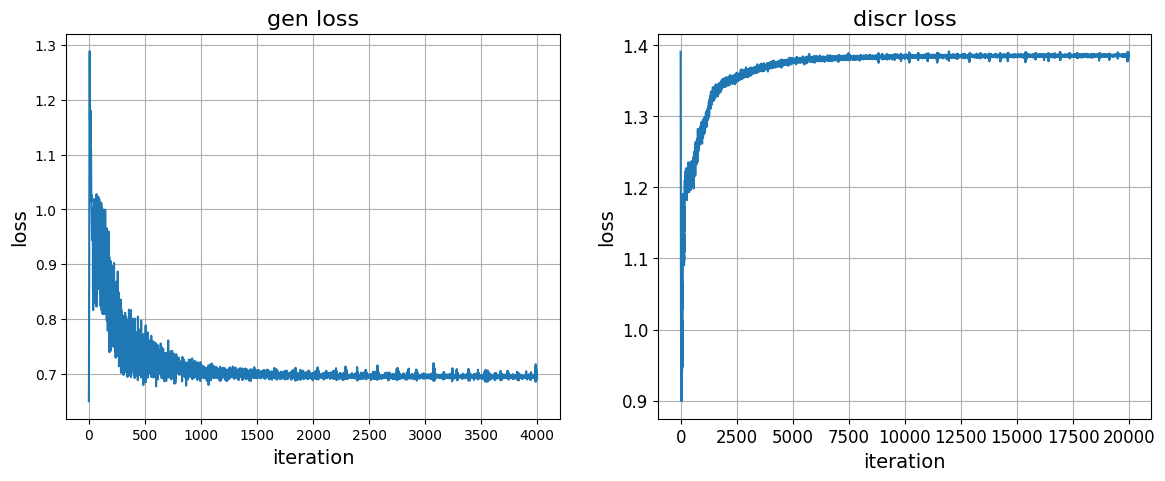

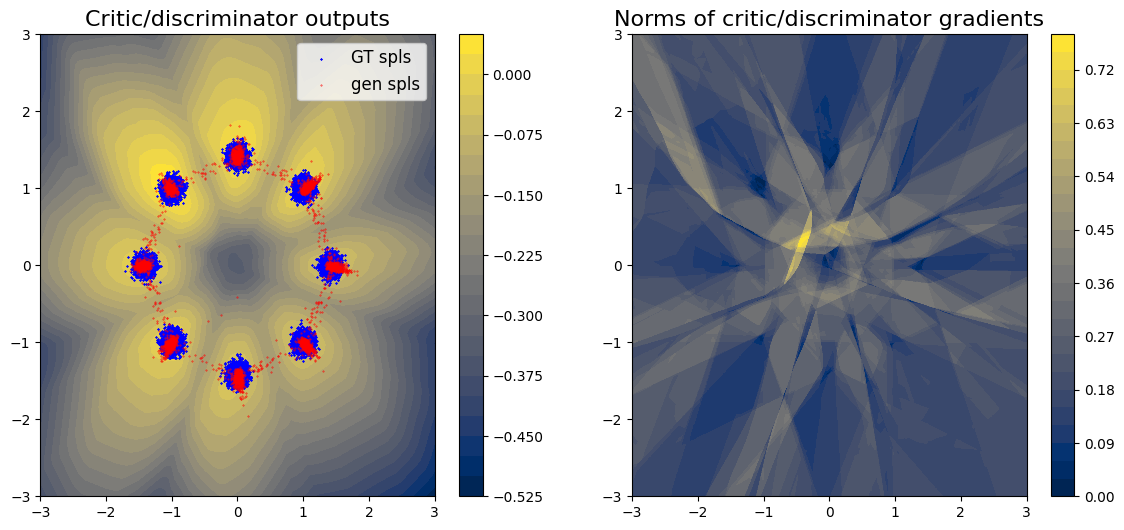

In [ ]:
diagnostic.visualize()

## 3. GANs on $3\times 16\times 16$ image data

Now we apply our implemented `Vanilla GAN` and `NS GAN R_1` approaches to solve the Generative Modelling problem on the $3\times 16\times 16$ image data

### 3.1 Image data problem setup

As the distribution $\mathbb{P}$ we aim to model, we consider **Colored MNIST** dataset downscaled to $16\times 16$ spatial resolutions. You will meet this distribution in the further seminars again 🙂.

* Look into the code below carefully

* Note that __Colored MNIST__ dataset produces images with the pixel range $[-1, 1]$.

In [ ]:
import torchvision.datasets as TVdatasets
from torchvision import transforms as TVtransforms

# draw grayscaled image with random color
def random_color(im : torch.Tensor) -> torch.Tensor:
    hue = 360*np.random.rand()
    d = (im *(hue%60)/60)
    im_min, im_inc, im_dec = torch.zeros_like(im), d, im - d
    H = round(hue/60) % 6
    cmap = [[0, 3, 2], [2, 0, 3], [1, 0, 3], [1, 2, 0], [3, 1, 0], [0, 1, 2]]
    return torch.cat((im, im_min, im_dec, im_inc), dim=0)[cmap[H]]

class CMNISTDataset(torch.utils.data.Dataset):

    def __init__(
        self,
        train : bool =True,
        spat_dim : Tuple[int, int] = (16, 16),
        download : bool = False,
        pix_range : Tuple[float, float] = (-1., 1.)
    ) -> None:
        _m, _std = pix_range[0]/float(pix_range[0] - pix_range[1]), 1./float(pix_range[1] - pix_range[0])
        TRANSFORM = TVtransforms.Compose([
            TVtransforms.Resize(spat_dim),
            TVtransforms.ToTensor(),
            random_color,
            TVtransforms.Normalize([_m],[_std])
        ])
        self.mnist = TVdatasets.MNIST(root='./data', train=train, download=download, transform=TRANSFORM)

    def __len__(self):
        return len(self.mnist)

    def __getitem__(self, idx : int) -> torch.Tensor:
        return self.mnist[idx][0]

cmnist_train = CMNISTDataset(train=True, download=True)
cmnist_test = CMNISTDataset(train=False)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9912422/9912422 [00:04<00:00, 2364788.66it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 28881/28881 [00:00<00:00, 218773.77it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1648877/1648877 [00:01<00:00, 1532206.17it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4542/4542 [00:00<00:00, 4599355.09it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Let us take a look at the images from the datasets.

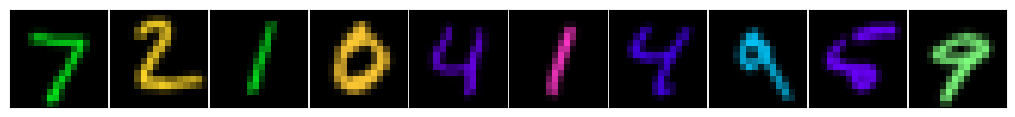

In [ ]:
REFERENCE_IMAGES = next(iter(DataLoader(cmnist_test, batch_size=10)))
plot_images(REFERENCE_IMAGES)

### 3.2 Implementing Vanilla GAN and NS GAN on image data

When people deal with images, they typically use Convolutional Neural Networks. Implement the generic classes for `ConvGenerator` $G : \mathbb{R}^{D_z} \rightarrow \mathbb{R}^{3 \times 16 \times 16}$ and `ConvDiscriminator` $D : \mathbb{R}^{3 \times 16 \times 16} \rightarrow \mathbb{R}$ below. For now, do not restrict somehow the output of the `ConvDiscriminator` class

#### `ConvGenerator`

* Takes a latent sample (vector) of size `(batch_size, input_size)` as input, produces a tensor of shape `(batch_size, 3, 16, 16)` as output.

* The output tensor values are in range $[-1, 1]$.

* Implements `sample` method. Choose standard Normal distribution as $p_z$.

💡 **Hint:** Start with linear block, then combine several `nn.ConvTranspose2d` ([docs](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html)) blocks with `BatchNorm2d` and `ReLU` nonlinearity.

#### `ConvDiscriminator`

* For now, do not restrict somehow the output of the `ConvDiscriminator` class.

* Takes an image tensor `(batch_size, 3, 16, 16)` as the input, produces scalar values of size `(batch_size, 1)` as output

💡 **Hint:** Just combine several `nn.Conv2d` layers with `LeakyReLU` nonlinearity. Apply linear layer at the end.

In [ ]:
class ConvGenerator(nn.Module):

    def __init__(
        self, input_size: int = 128,
    ) -> None:
        super().__init__()
        self.n_channels = 64
        self.input_size = input_size
        self.linear_block = nn.Sequential(
            nn.Linear(input_size, 4 * 4 * 4 * self.n_channels),
            nn.ReLU(True),
        )
        self.conv_block = nn.Sequential(
            nn.ConvTranspose2d(4 * self.n_channels, 2 * self.n_channels, 2, stride=2),
            nn.BatchNorm2d(2 * self.n_channels),
            nn.ReLU(True),
            nn.ConvTranspose2d(2 * self.n_channels, self.n_channels, 2, stride=2),
            nn.BatchNorm2d(self.n_channels),
            nn.ReLU(True),
            nn.Conv2d(self.n_channels, 3, 3, padding=1)
        )
        self.noise = torch.distributions.Normal(torch.tensor(0.0), torch.tensor(1.0))

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        assert input.size(1) == self.input_size
        output = self.linear_block(input)
        output = output.view(-1, 4 * self.n_channels, 4, 4)
        output = self.conv_block(output)
        output = torch.tanh(output)
        return output.view(-1, 3, 16, 16)

    def sample(self, n_samples: int) -> torch.Tensor:
        z = self.noise.sample([n_samples, self.input_size]).to(next(iter(self.parameters())))
        return self.forward(z)

class ConvDiscriminator(nn.Module):

    def __init__(self) -> None:
        super().__init__()
        self.n_channels = 64

        self.net = nn.Sequential(
            nn.Conv2d(3, self.n_channels, 3, stride=2, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(self.n_channels, 2 * self.n_channels, 3, stride=2, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(2 * self.n_channels, 4 * self.n_channels, 3, stride=2, padding=1),
            nn.LeakyReLU(),
        )
        self.linear = nn.Linear(4 * 2 * 2 * self.n_channels, 1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        output = self.net(x)
        output = output.view(-1, 4 * 2 * 2 * self.n_channels)
        output = self.linear(output)
        return output

CG = ConvGenerator()
CD = ConvDiscriminator()

`ConvDiscriminator` for __Vanilla GAN__

You know what to do.

In [ ]:
class VanillaConvDiscriminator(ConvDiscriminator):

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        output = super().forward(x)
        return torch.sigmoid(output)

### 3.3 Training on image data

#### Training `Vanilla GAN` on image data

* use `train_vanilla` function you implement in the previous sections

* do not forget that the discriminator's outpus should be restricted

  0%|                                                                                                                                                | 0/10 [00:00<?, ?it/s]

Epoch 0


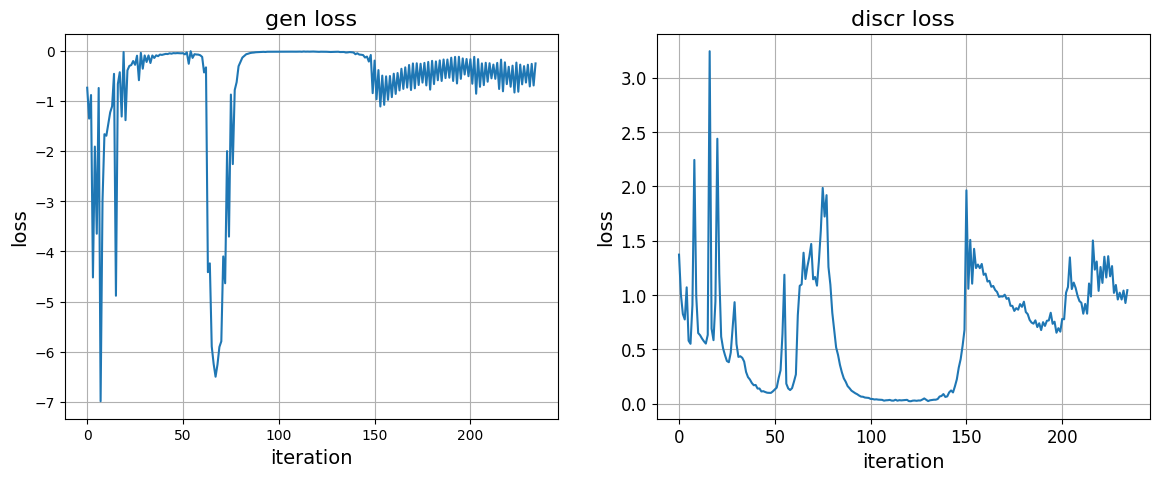

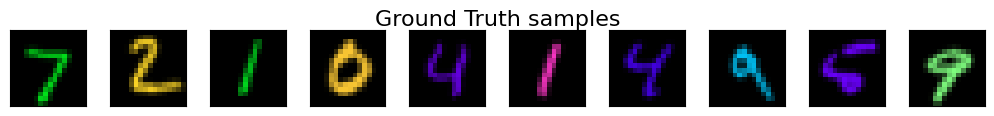

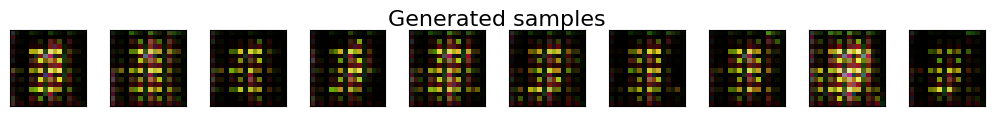

 10%|█████████████▌                                                                                                                          | 1/10 [00:30<04:32, 30.32s/it]

Epoch 1


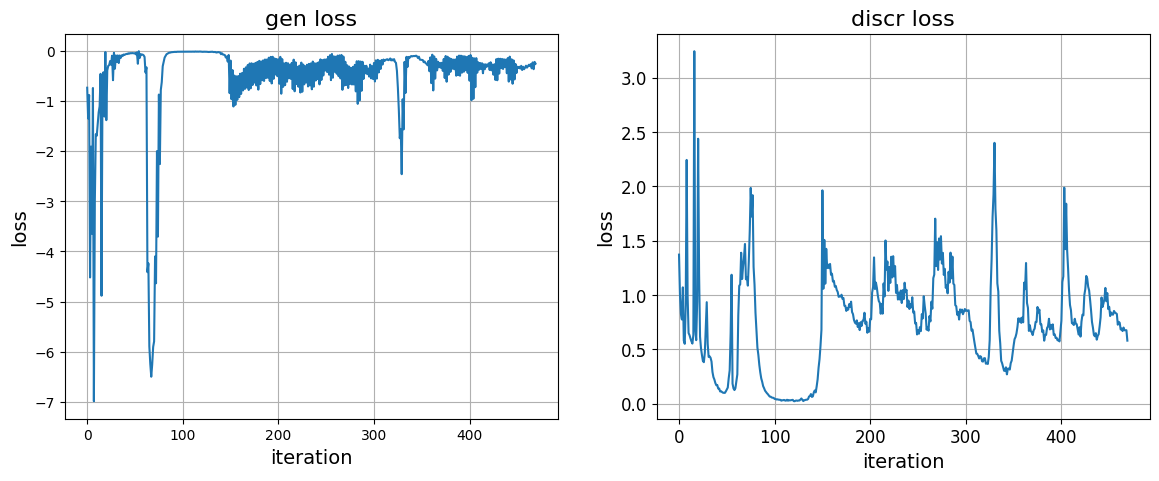

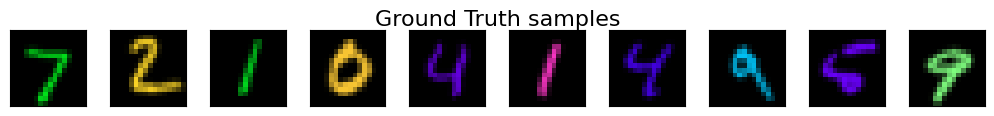

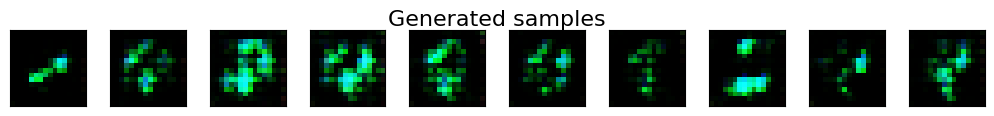

 20%|███████████████████████████▏                                                                                                            | 2/10 [01:00<04:00, 30.05s/it]

Epoch 2


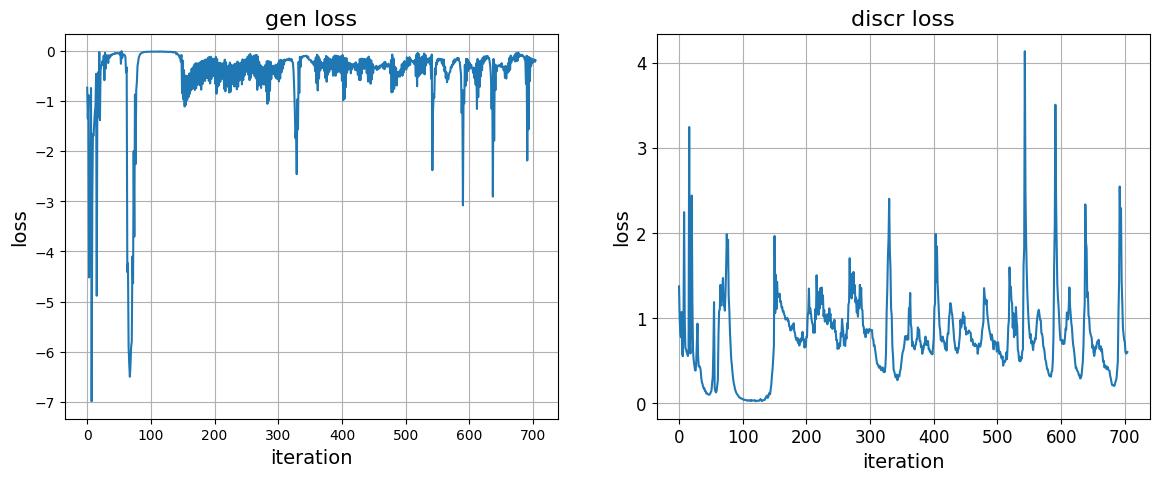

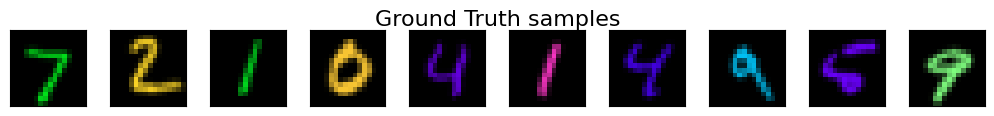

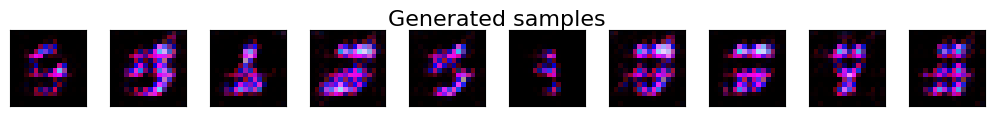

 30%|████████████████████████████████████████▊                                                                                               | 3/10 [01:30<03:29, 29.99s/it]

Epoch 3


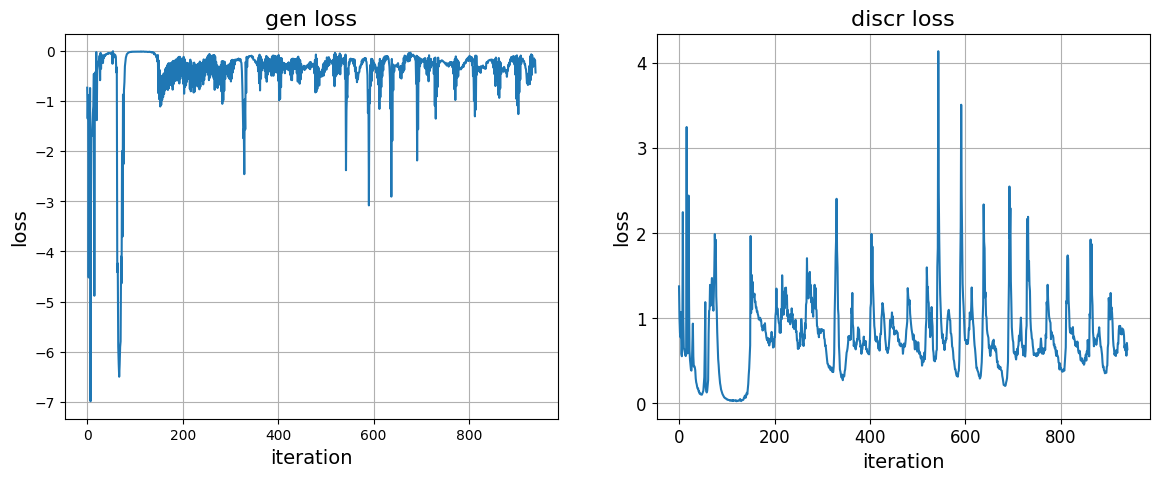

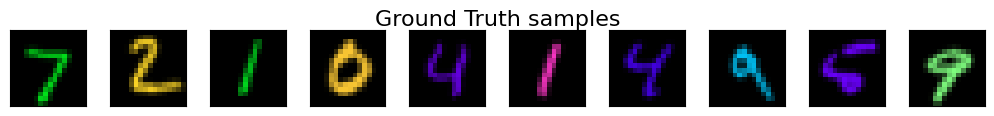

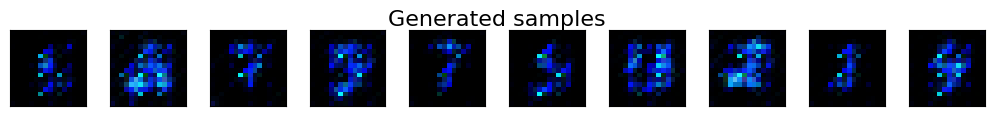

 40%|██████████████████████████████████████████████████████▍                                                                                 | 4/10 [02:00<02:59, 29.97s/it]

Epoch 4


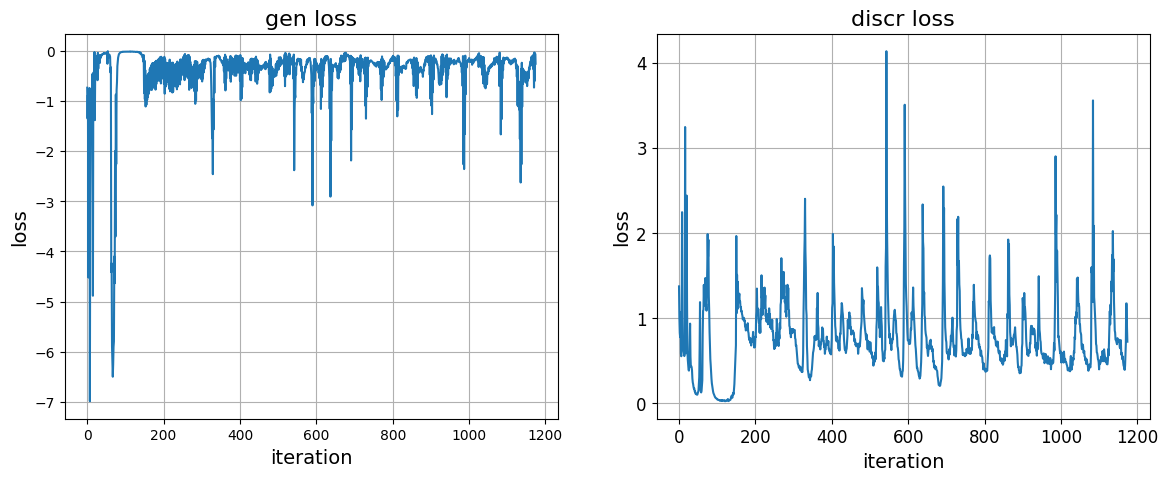

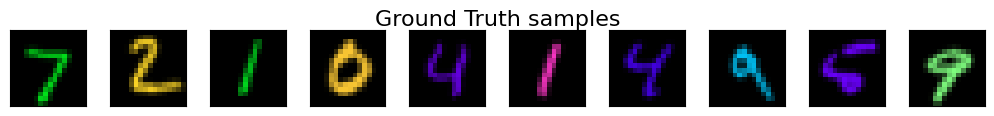

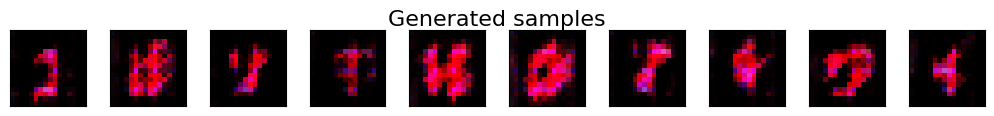

 50%|████████████████████████████████████████████████████████████████████                                                                    | 5/10 [02:29<02:29, 29.93s/it]

Epoch 5


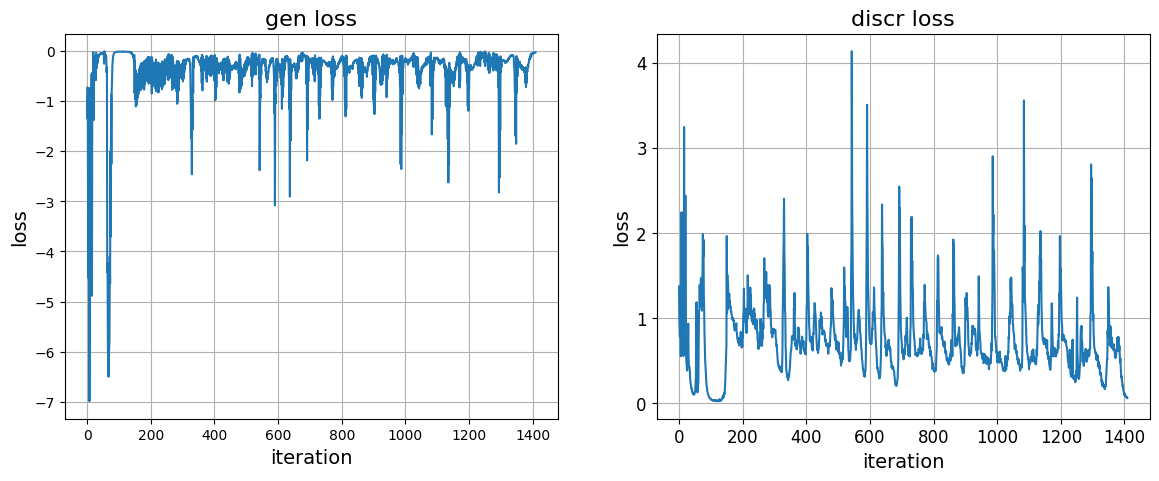

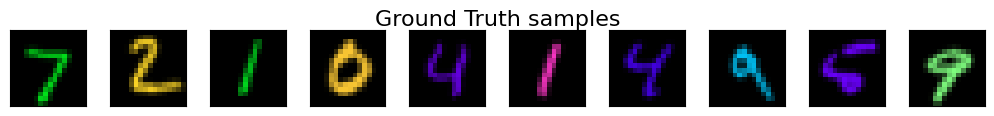

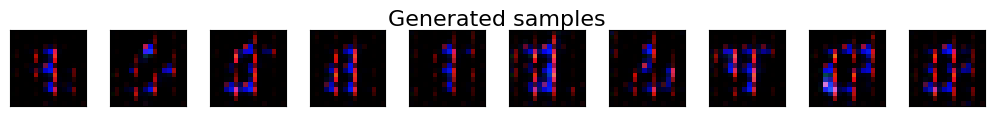

 60%|█████████████████████████████████████████████████████████████████████████████████▌                                                      | 6/10 [02:59<01:59, 29.94s/it]

Epoch 6


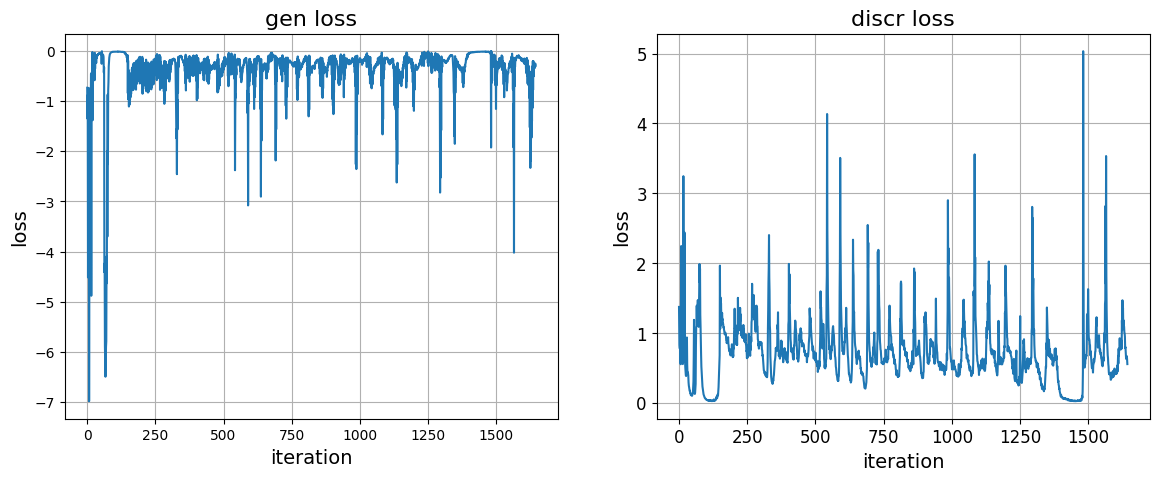

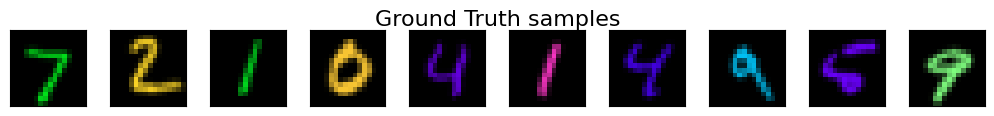

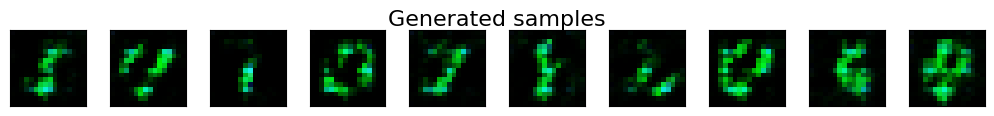

 70%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 7/10 [03:29<01:29, 29.90s/it]

Epoch 7


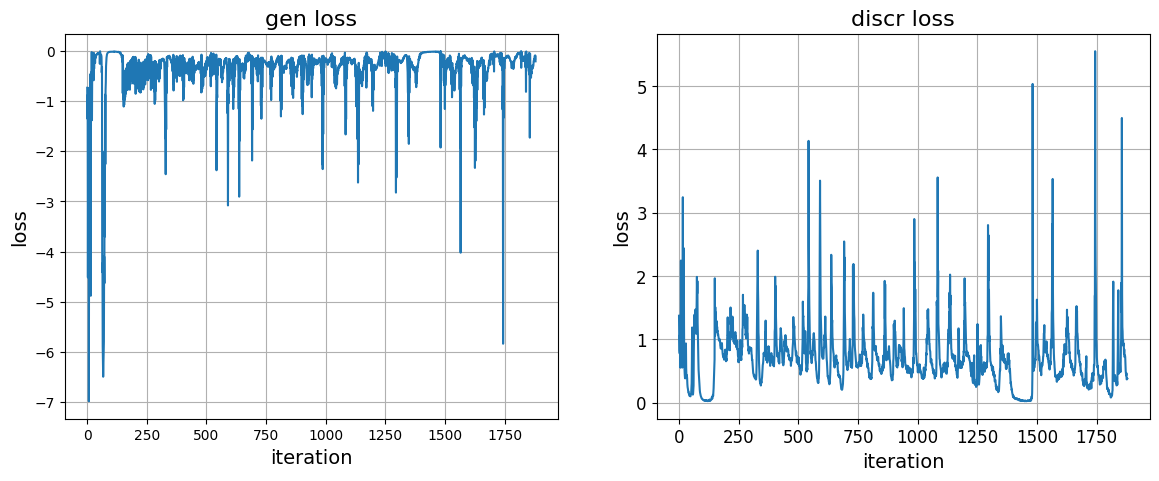

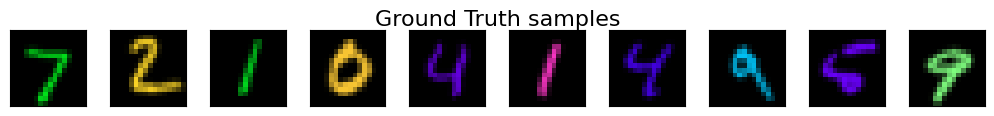

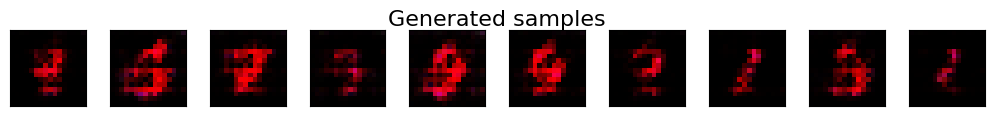

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 8/10 [03:59<00:59, 29.83s/it]

Epoch 8


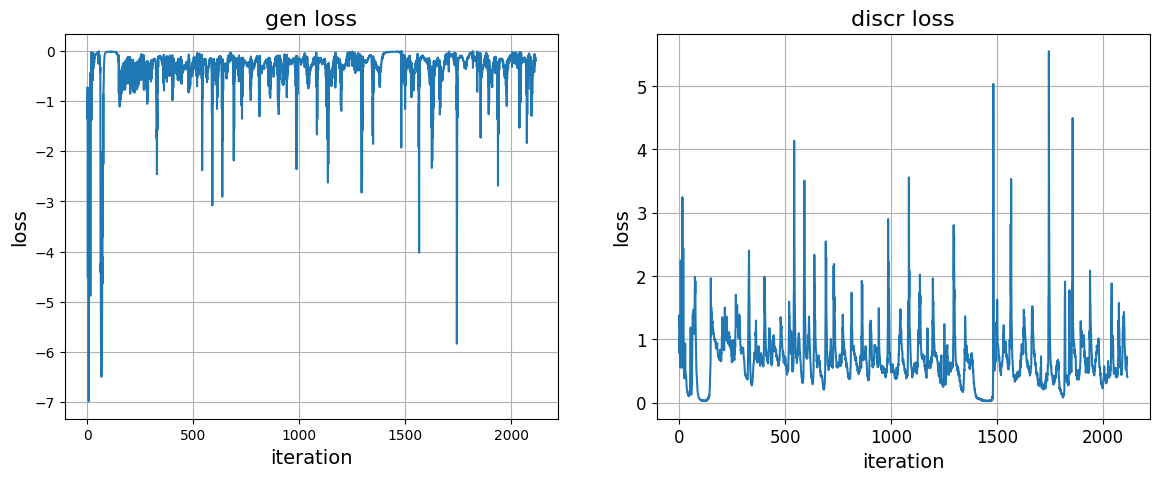

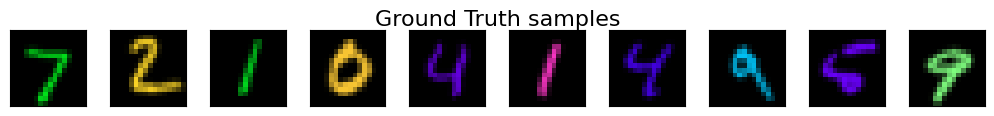

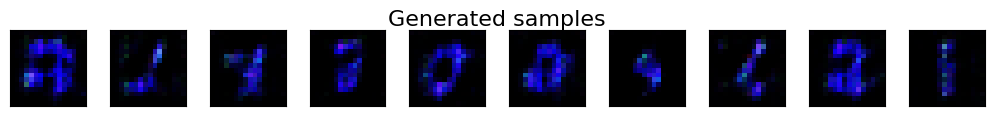

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 9/10 [04:28<00:29, 29.67s/it]

Epoch 9


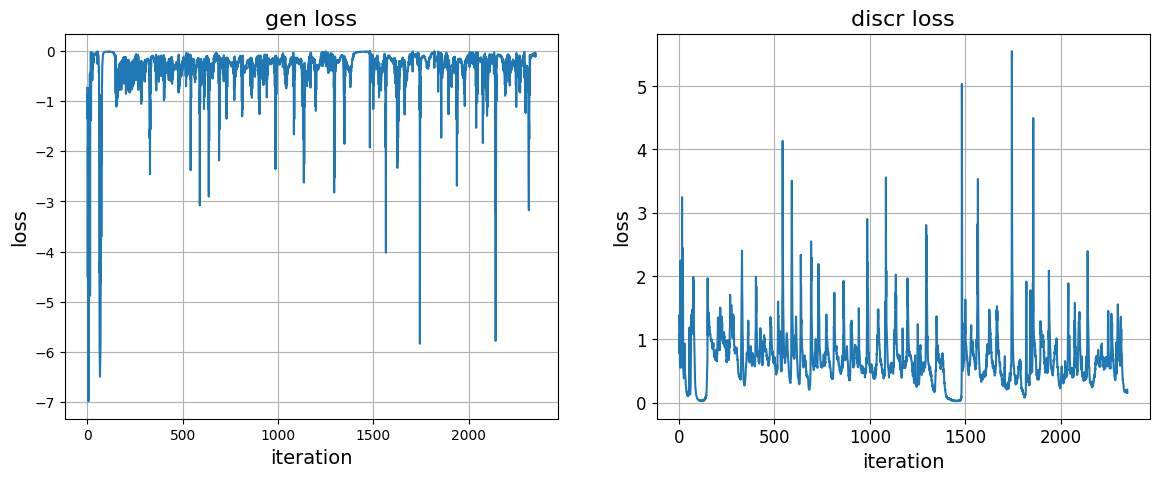

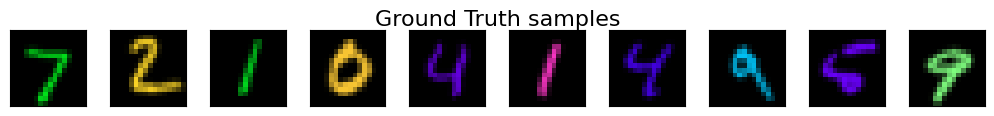

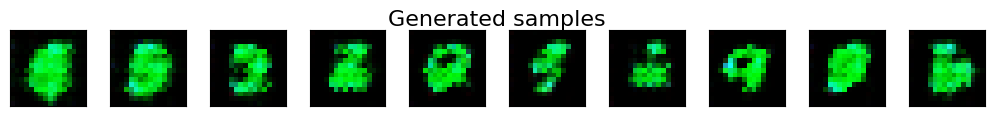

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [04:57<00:00, 29.78s/it]


In [ ]:
BATCH_SIZE = 256
DISCRIMINATOR_STEPS = 1 # >=2 - no learning, saturation!, 1 - something manages to learn
LR = 2e-4 # < 1e-2
N_EPOCHS = 10 # change it if you want

train_mnist_loader = DataLoader(cmnist_train, batch_size=BATCH_SIZE, shuffle=True)
G = ConvGenerator().to(DEVICE)
D = VanillaConvDiscriminator().to(DEVICE)
G_optim = torch.optim.RMSprop(G.parameters(), lr=LR)
D_optim = torch.optim.RMSprop(D.parameters(), lr=LR)
diagnostic = GANDiagnosticCompanionImages(G, D, REFERENCE_IMAGES.numpy())

train_losses = train_vanilla(
    train_mnist_loader,
    G,
    D,
    G_optim,
    D_optim,
    discriminator_steps=DISCRIMINATOR_STEPS,
    n_epochs=N_EPOCHS,
    diagnostic=diagnostic,
    visualize_steps=1
)

Diagnostic after `10` epochs

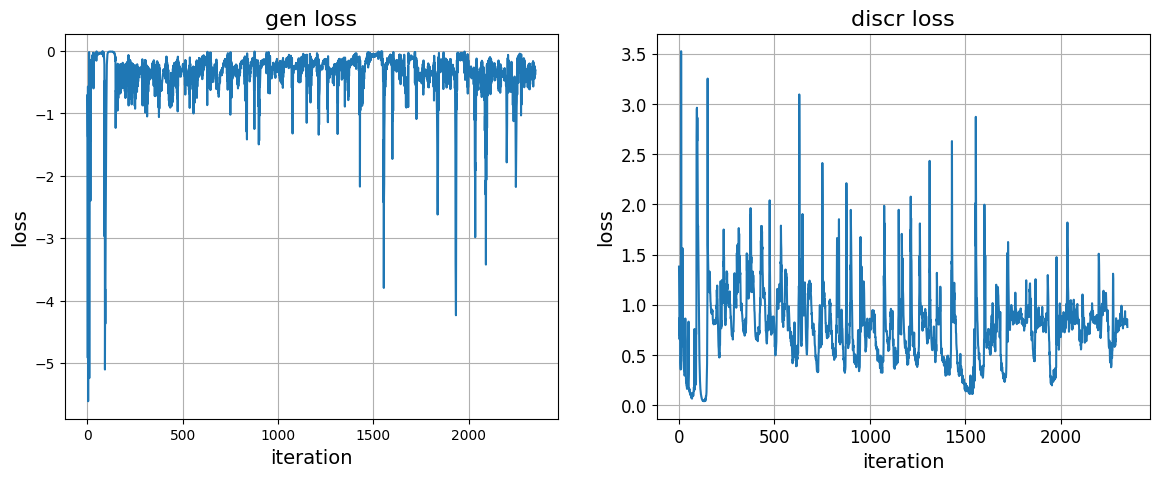

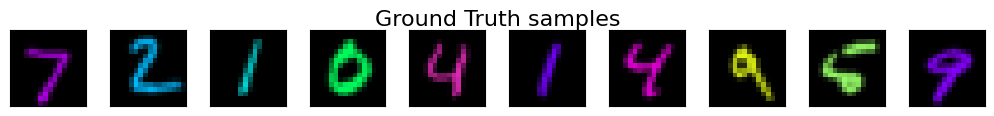

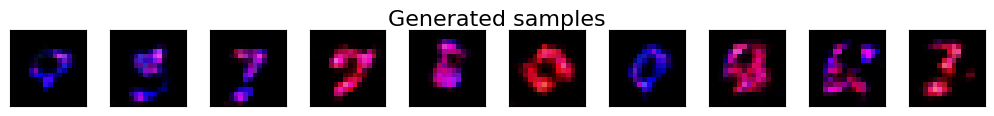

In [ ]:
diagnostic.visualize()

Samples after `70` epochs of a <u>successful</u> launch.

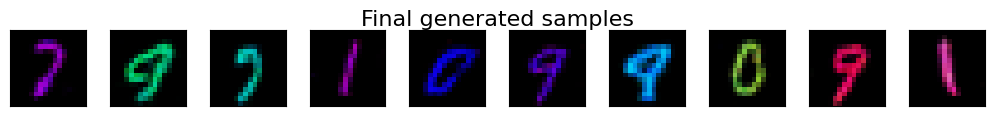

In [ ]:
GENERATED_SAMPLES = G.sample(10).detach().cpu()
plot_images(GENERATED_SAMPLES, 'Final generated samples')

#### Training `NS GAN` on image data

* use `train_ns` function you implement in the previous sections

  0%|                                                                                                                                                | 0/10 [00:00<?, ?it/s]

Epoch 0


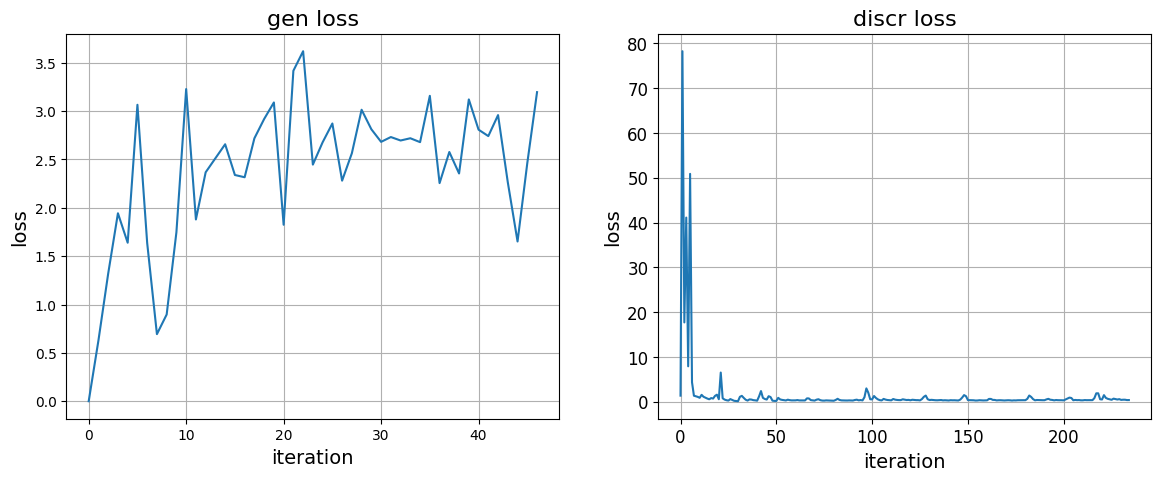

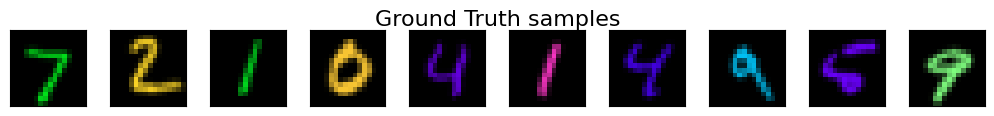

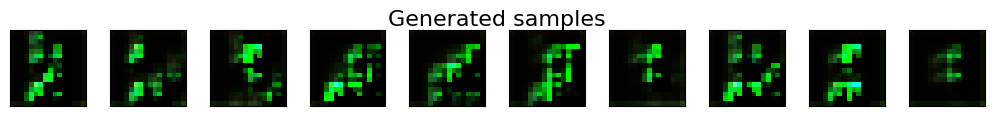

 10%|█████████████▌                                                                                                                          | 1/10 [00:29<04:21, 29.01s/it]

Epoch 1


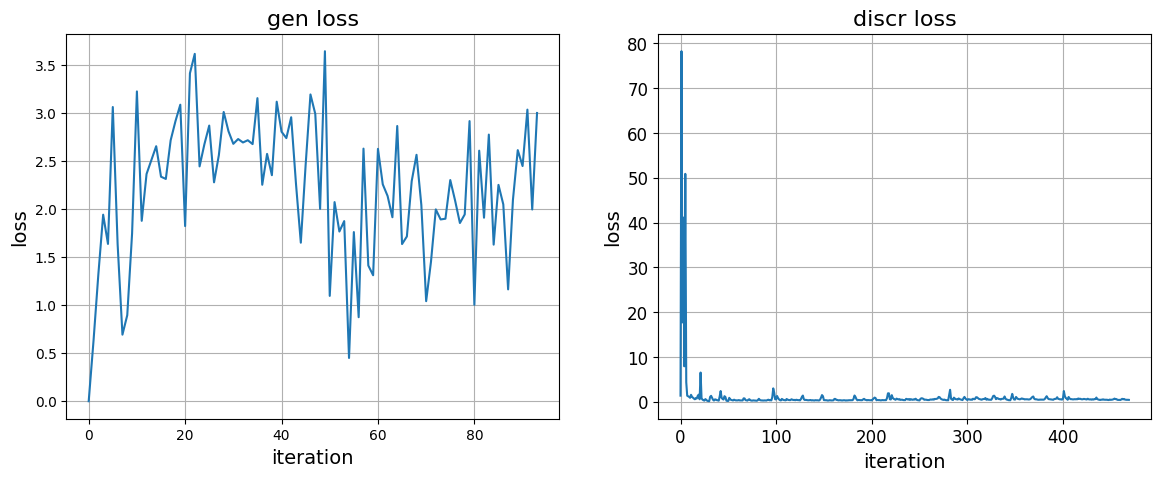

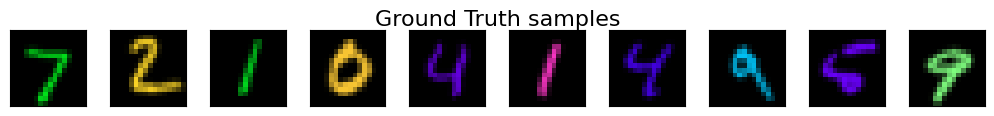

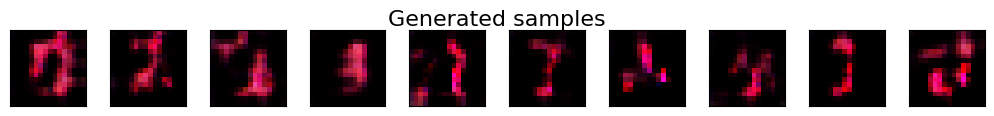

 20%|███████████████████████████▏                                                                                                            | 2/10 [00:58<03:52, 29.09s/it]

Epoch 2


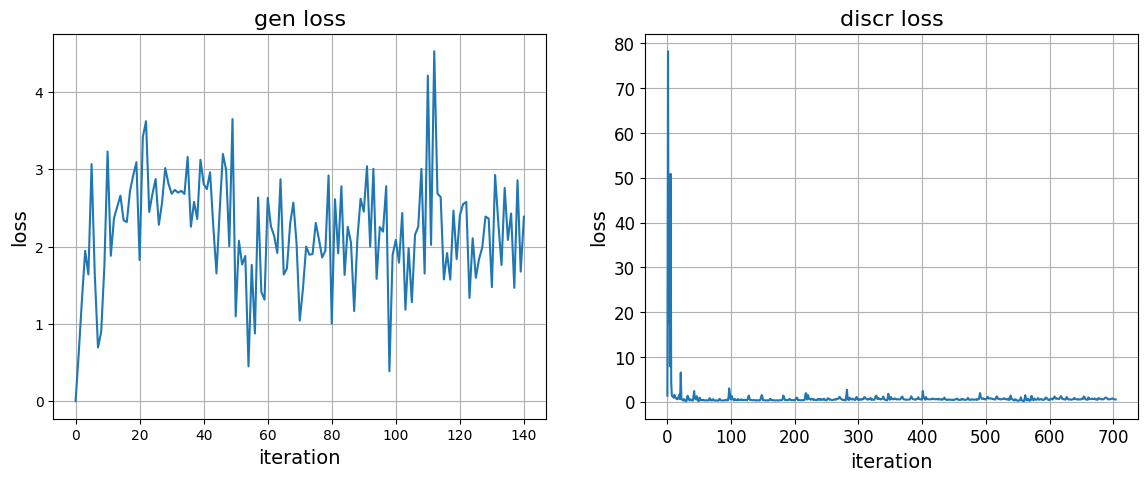

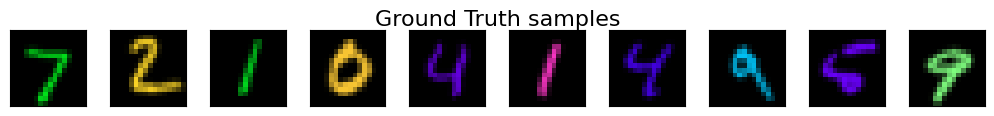

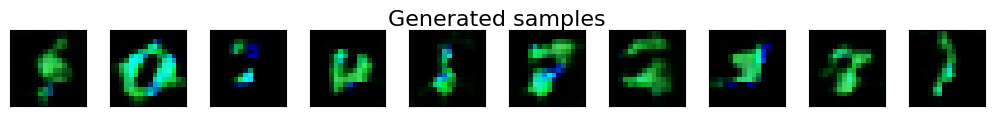

 30%|████████████████████████████████████████▊                                                                                               | 3/10 [01:27<03:25, 29.36s/it]

Epoch 3


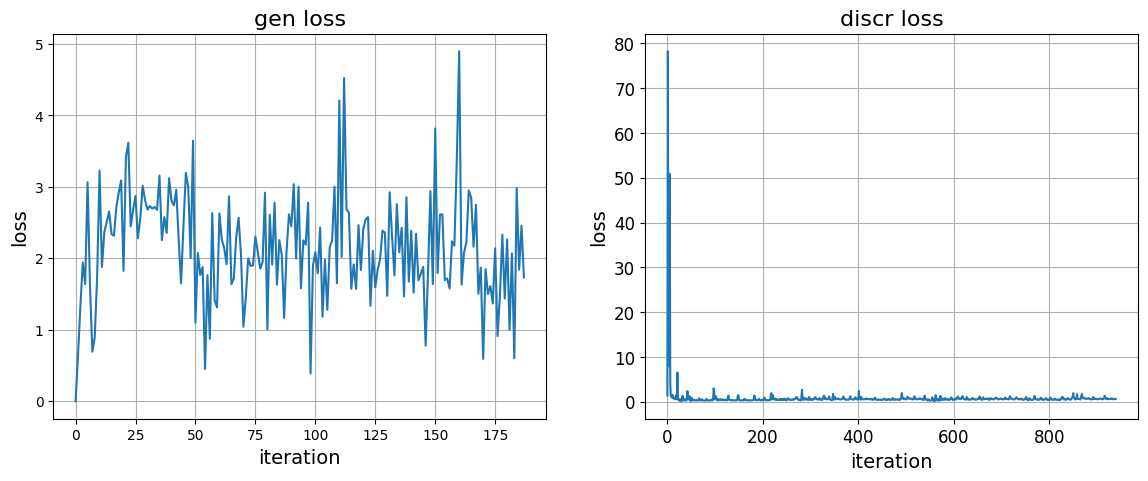

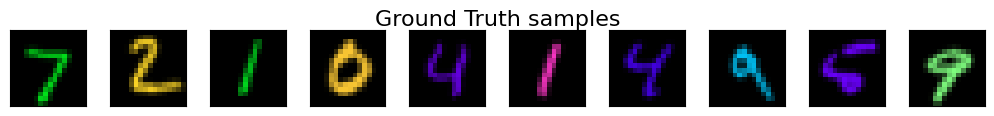

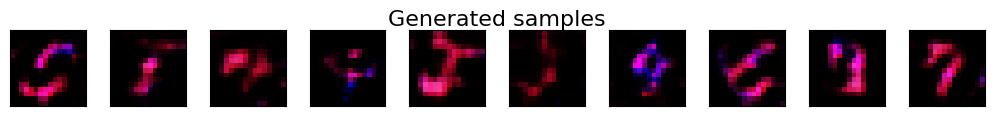

 40%|██████████████████████████████████████████████████████▍                                                                                 | 4/10 [01:57<02:57, 29.51s/it]

Epoch 4


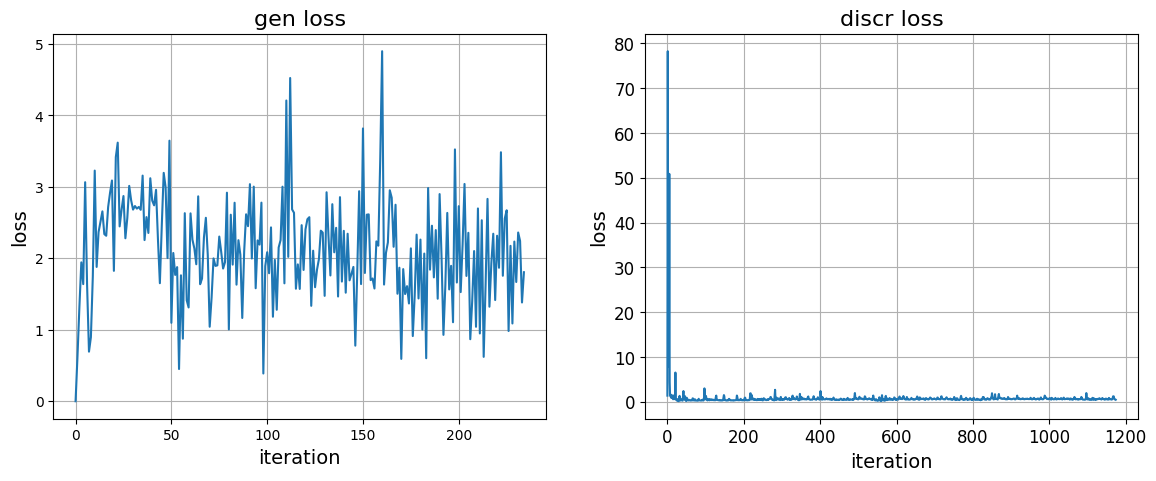

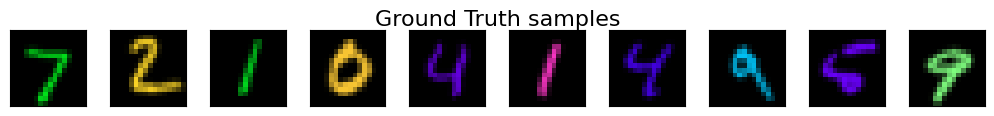

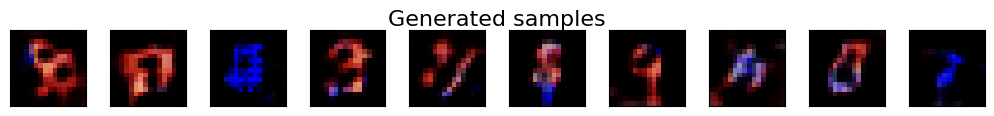

 50%|████████████████████████████████████████████████████████████████████                                                                    | 5/10 [02:26<02:27, 29.47s/it]

Epoch 5


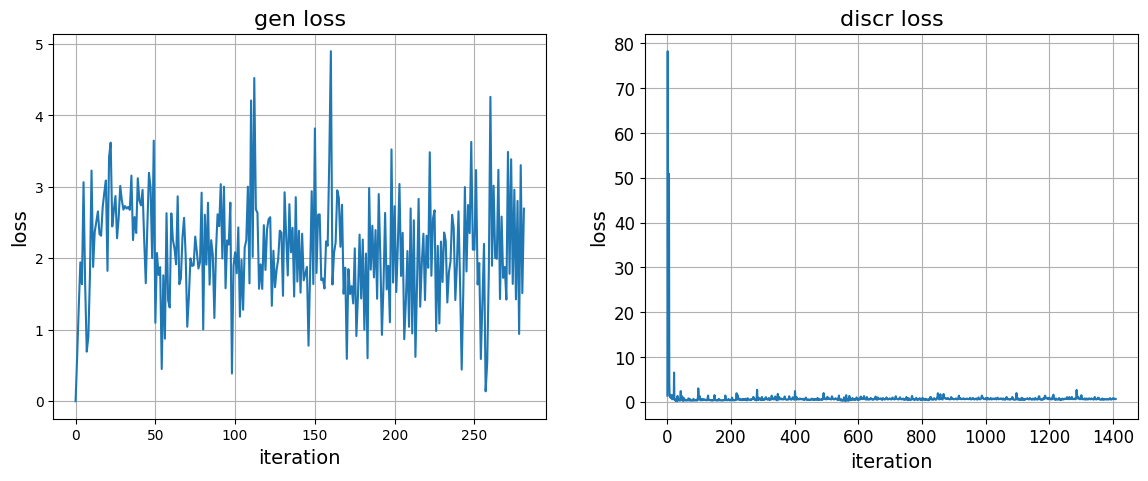

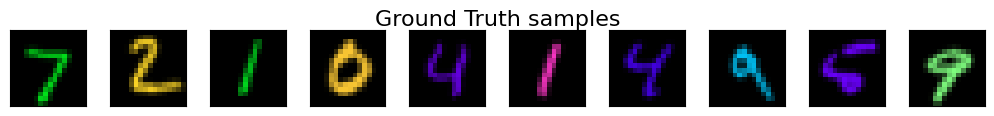

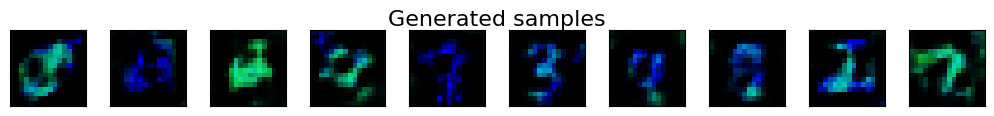

 60%|█████████████████████████████████████████████████████████████████████████████████▌                                                      | 6/10 [02:56<01:57, 29.43s/it]

Epoch 6


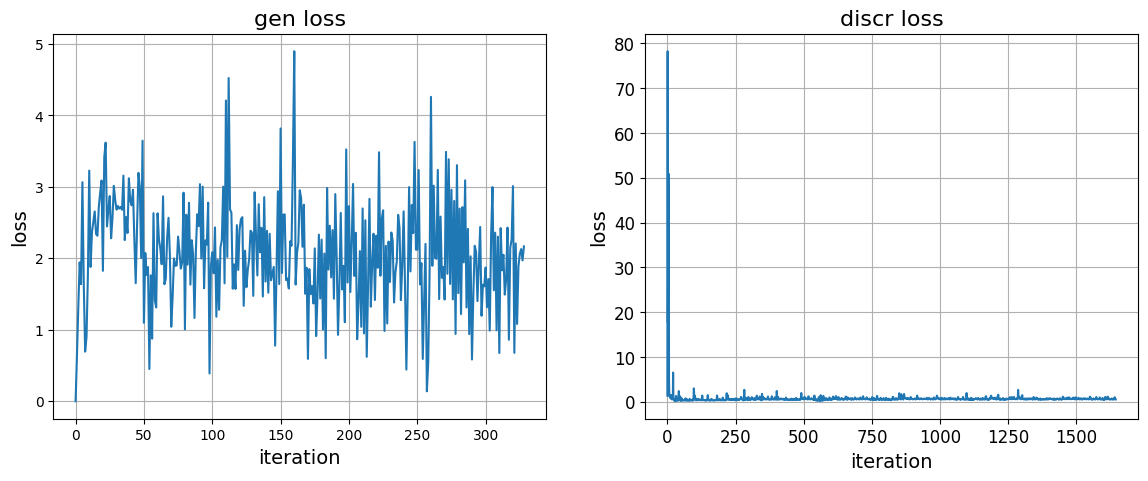

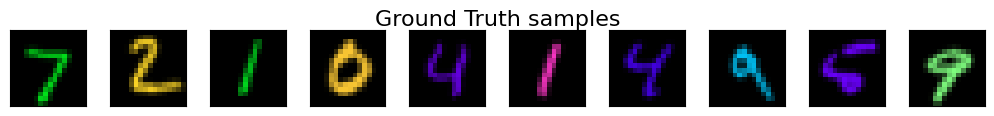

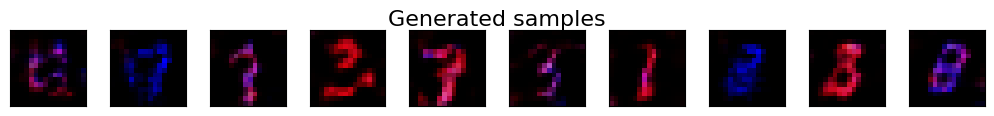

 70%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 7/10 [03:25<01:28, 29.45s/it]

Epoch 7


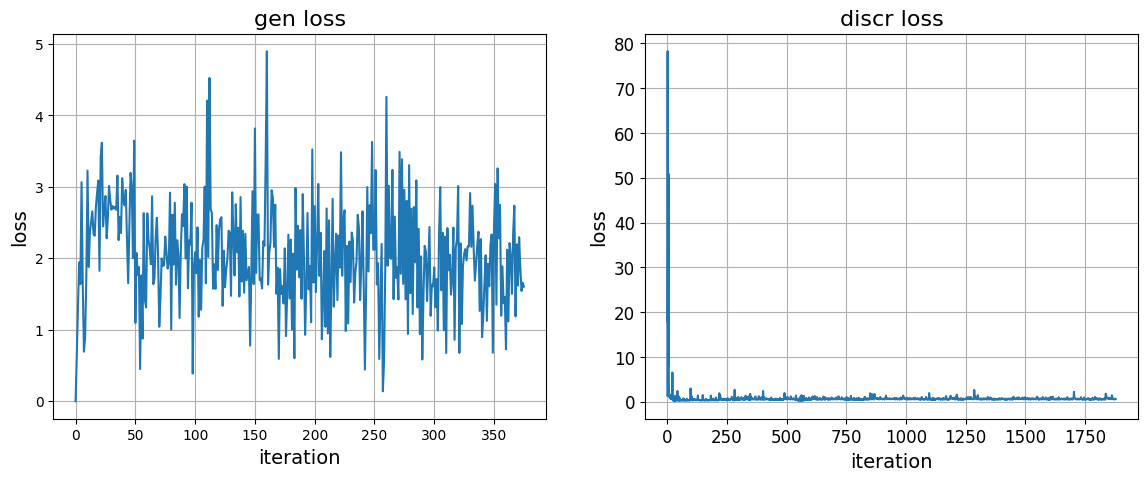

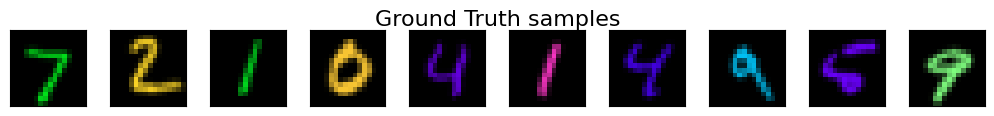

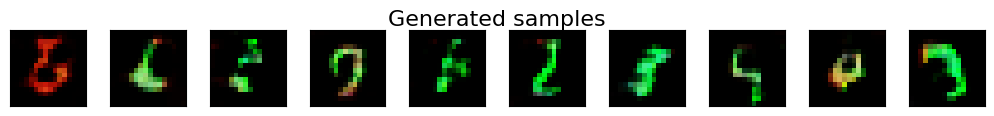

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 8/10 [03:55<00:58, 29.45s/it]

Epoch 8


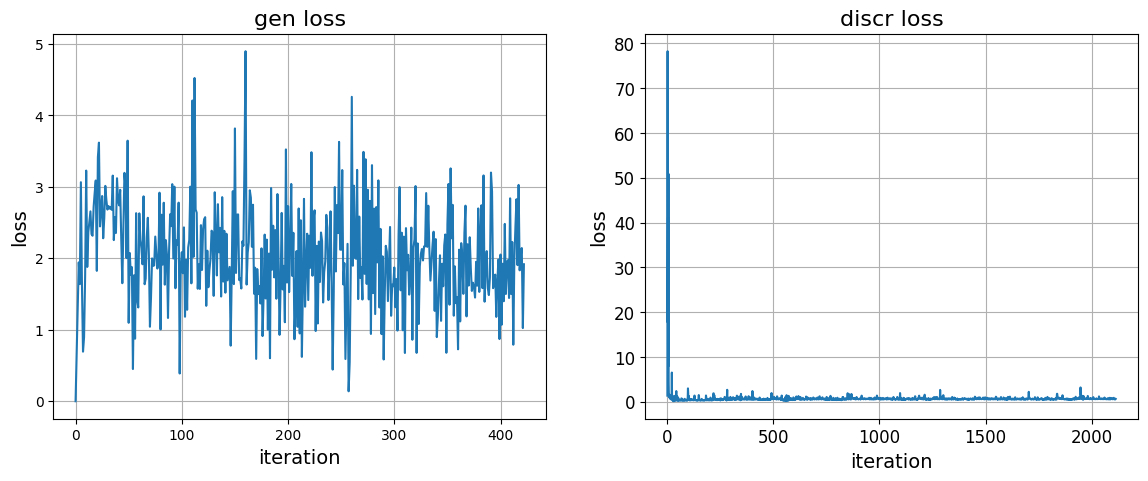

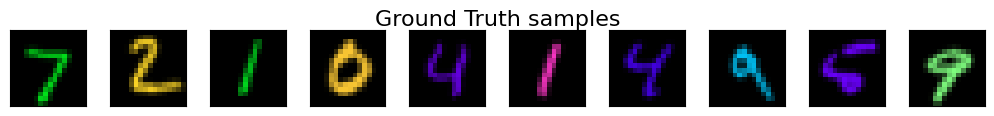

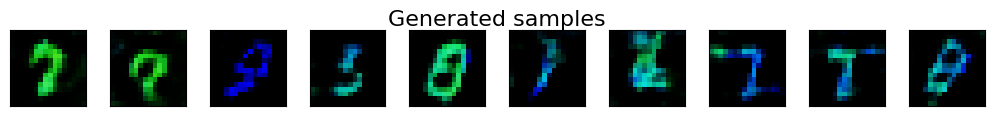

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 9/10 [04:24<00:29, 29.45s/it]

Epoch 9


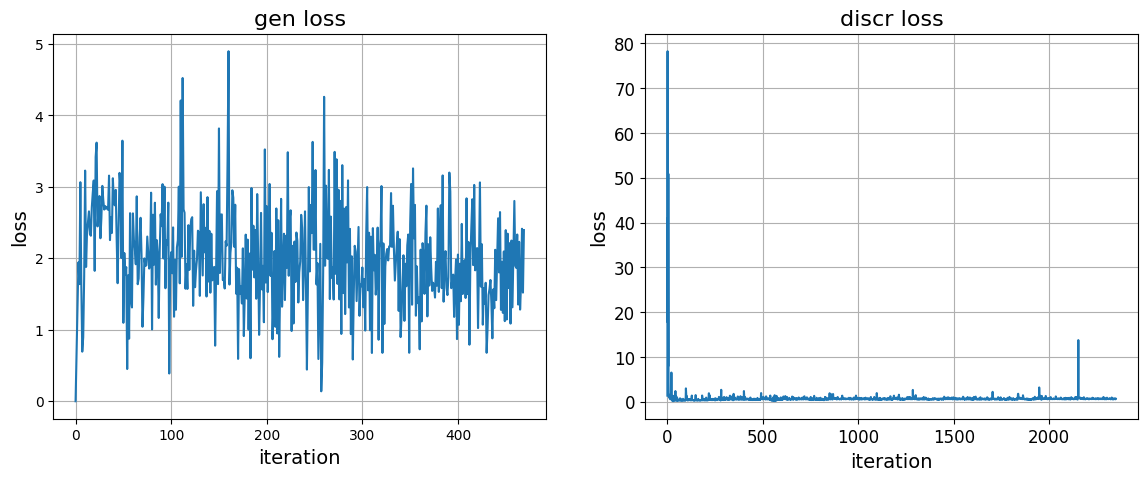

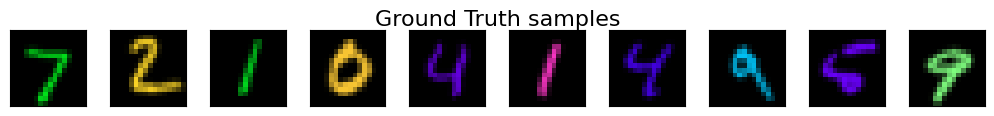

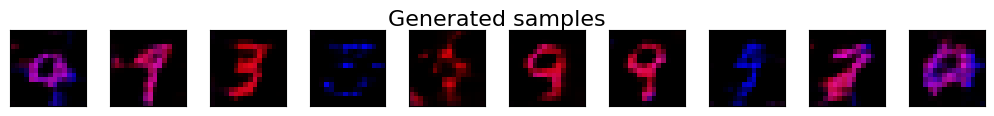

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [04:53<00:00, 29.40s/it]


In [ ]:
BATCH_SIZE = 256
DISCRIMINATOR_STEPS = 5 # 5 is ok
LR = 2e-3 # < 1e-2
R1_REGULARIZER = 0.1
N_EPOCHS = 10 # change it if you want

train_mnist_loader = DataLoader(cmnist_train, batch_size=BATCH_SIZE, shuffle=True)
G = ConvGenerator().to(DEVICE)
D = ConvDiscriminator().to(DEVICE)
G_optim = torch.optim.RMSprop(G.parameters(), lr=LR)
D_optim = torch.optim.RMSprop(D.parameters(), lr=LR)
diagnostic = GANDiagnosticCompanionImages(G, D, REFERENCE_IMAGES.numpy())

train_losses = train_ns(
    train_mnist_loader,
    G,
    D,
    G_optim,
    D_optim,
    discriminator_steps=DISCRIMINATOR_STEPS,
    n_epochs=N_EPOCHS,
    diagnostic=diagnostic,
    r1_regularizer=R1_REGULARIZER,
    visualize_steps=1
)

Diagnostic after `10` epochs

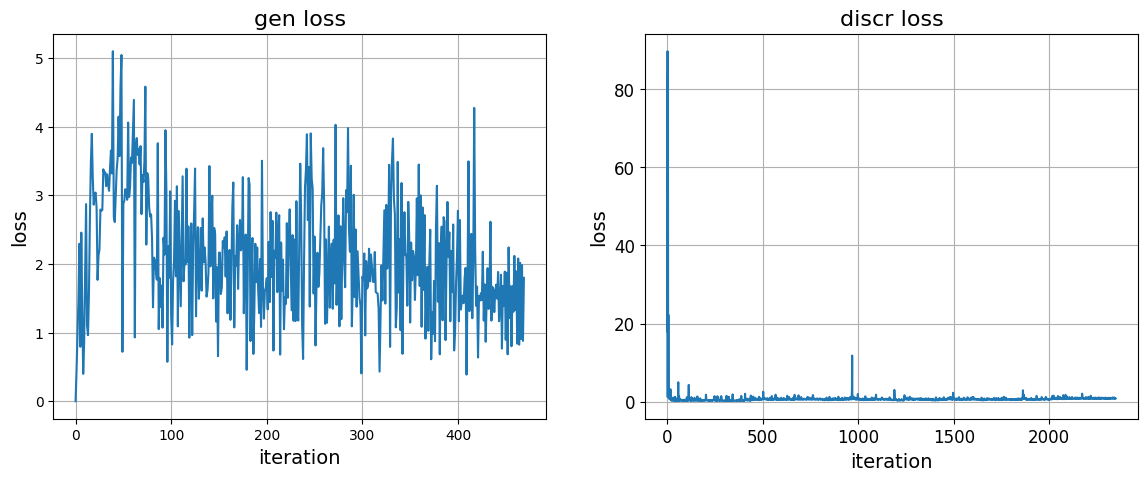

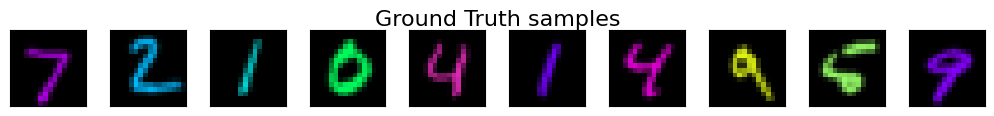

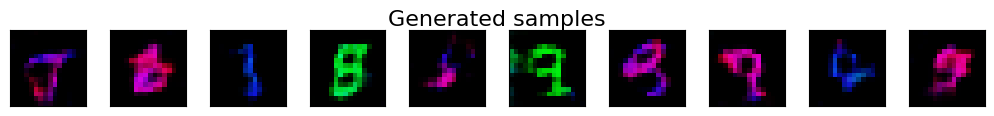

In [ ]:
diagnostic.visualize()

Samples after `100` epochs

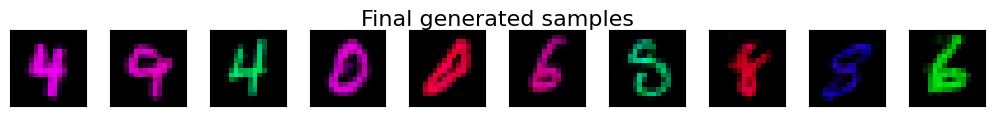

In [ ]:
GENERATED_SAMPLES = G.sample(10).detach().cpu()
plot_images(GENERATED_SAMPLES, 'Final generated samples')

**Conclusion**

When applying GANs on complex data (e.g., images) one need to properly <u>regularize your models</u>.

🔎 __Remark.__ Except __NS GAN__ with __$R_1$ regularization__, a popular choise of well-behaving regularized GAN loss is __Wasserstein GAN__ with __Gradient Penalty__. For more information, see original *Wasserstein GAN* [paper](https://arxiv.org/abs/1701.07875) and *Improved Training of Wasserstein GANs* [paper](https://arxiv.org/abs/1704.00028) (the latter introduces WGAN with GP).

## I know everything from above, let me do something interesting.

❔__Additional exercise.__ Learn **NS GAN $R_1$** on `Cifar10` dataset. Come up with your own architectures for the generator and the discriminator, download the dataset, tune hyperparameters and launch `train_ns` function. Demonstrate the samples.